In [ ]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [ ]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_4178/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


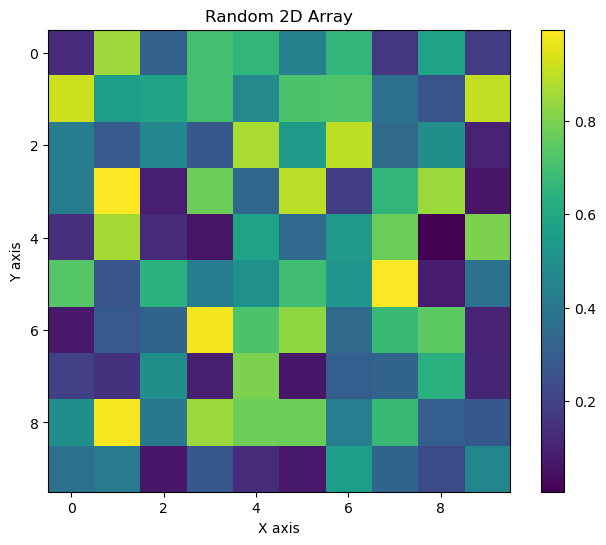

In [ ]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [ ]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################


            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################

                        
                        
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [ ]:
# ### my_snn control board ########################
# decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save


# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "4",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 8 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 34, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'NMNIST_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1,
#                 synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1,
#                 synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 1, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 1_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [ ]:
# # dfa code from ASAP
# class feedback_receiver(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, input, weight_fb):
#         output = input.clone()
#         dummy = torch.Tensor(input.size()[0],weight_fb.size()[0]).zero_().to(input.device)
#         ctx.save_for_backward(weight_fb,)
#         ctx.shape = input.shape
#         return output, dummy
    
#     @staticmethod
#     def backward(ctx, grad_output, grad_dummy):
#         weight_fb, = ctx.saved_tensors
#         input_size = ctx.shape
#         grad_weight_fb = None
        
#         grad_input = torch.mm(grad_dummy.view(grad_dummy.size()[0],-1), weight_fb).view(input_size) # Batch_size, input
#         return grad_input, grad_weight_fb


# class Feedback_Receiver(nn.Module):
#     def __init__(self, connect_features):
#         super(Feedback_Receiver, self).__init__()
#         self.connect_features = connect_features
#         self.weight_fb = None
    
#     def forward(self, input):
#         if self.weight_fb is None:
#             self.weight_fb = nn.Parameter(torch.Tensor(self.connect_features, *input.size()[1:]).view(self.connect_features, -1)).to(input.device)
#             nn.init.normal_(self.weight_fb, std = math.sqrt(1./self.connect_features))
#         return feedback_receiver.apply(input, self.weight_fb)
   

In [ ]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': 'my_snn_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"min": 0.0001, "max": 0.01},
        "BATCH": {"values": [64,128,256,512]},
        "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [5,6,7,8,9,10]},
        "epoch_num": {"values": [15]},
        "dvs_duration": {"values": [10_000, 100_000, 25_000, 50_000]},
        "dvs_clipping": {"values": [1,2,4]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [True, False]},
        "surrogate": {"values": ['rectangle', 'sigmoid']},
        "cfg": {"values": [['M','M',200,200], ['M','M',200,200,200], ['M','M',200], ['M','M',512]]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    cfg  =  wandb.config.cfg

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "3",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = const2, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = const2, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',200,200], 
                cfg = cfg, 
                # cfg = [200,200],
                # cfg = [512], 
                # cfg = [64,128,'P',128,'P'], 
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 5xwsnf2d
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/5xwsnf2d


wandb: Agent Starting Run: jx2ai36d with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.008780093483049724
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.008780093483049724'], iter_loss:2.0378708839416504, tr:21.54%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [01:04<00:00,  3.79s/it]

epoch_time: 64.58790302276611 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008726044722796646'], iter_loss:1.251242756843567, tr:44.29%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [01:07<00:00,  4.00s/it] 

epoch_time: 68.12660026550293 seconds

EPOCH 2



2-16/17 iter:54.72%, lr=['0.00856522930189239'], iter_loss:1.2000902891159058, tr:53.57%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [01:09<00:00,  4.11s/it]

epoch_time: 69.96027970314026 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008301607029715401'], iter_loss:0.9910896420478821, tr:67.41%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [01:05<00:00,  3.84s/it]

epoch_time: 65.50902318954468 seconds

EPOCH 4



4-16/17 iter:66.04%, lr=['0.00794166916151884'], iter_loss:1.1771879196166992, tr:71.40%, val:51.89%, val_best:53.79%: 100%|██████████| 17/17 [00:59<00:00,  3.50s/it]

epoch_time: 59.56714177131653 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.007494278562183001'], iter_loss:0.8967857360839844, tr:77.72%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [01:09<00:00,  4.11s/it]

epoch_time: 70.05445051193237 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.006970451473067805'], iter_loss:1.5664852857589722, tr:81.34%, val:55.68%, val_best:56.06%: 100%|██████████| 17/17 [01:11<00:00,  4.22s/it]

epoch_time: 71.83514356613159 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.006383086255589705'], iter_loss:1.354087471961975, tr:90.44%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [01:10<00:00,  4.14s/it] 

epoch_time: 70.47370505332947 seconds

EPOCH 8



8-16/17 iter:94.34%, lr=['0.005746645790756409'], iter_loss:1.2584179639816284, tr:95.17%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [01:05<00:00,  3.83s/it]

epoch_time: 65.27723908424377 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0050768013550369145'], iter_loss:1.005887508392334, tr:97.68%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [01:10<00:00,  4.13s/it] 

epoch_time: 70.41392850875854 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.004390046741524863'], iter_loss:1.7930405139923096, tr:98.98%, val:62.88%, val_best:63.64%: 100%|██████████| 17/17 [01:04<00:00,  3.81s/it]

epoch_time: 64.88814425468445 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0037032921280128134'], iter_loss:0.9920451641082764, tr:99.35%, val:61.74%, val_best:63.64%: 100%|██████████| 17/17 [00:54<00:00,  3.22s/it] 

epoch_time: 54.88258337974548 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0030334476922933185'], iter_loss:1.2351181507110596, tr:99.54%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]

epoch_time: 68.60678577423096 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0023970072274600218'], iter_loss:1.234226942062378, tr:99.91%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:10<00:00,  4.12s/it] 

epoch_time: 70.23986768722534 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['0.0018096420099819224'], iter_loss:1.5764291286468506, tr:99.91%, val:64.39%, val_best:64.77%: 100%|██████████| 17/17 [01:09<00:00,  4.10s/it] 

epoch_time: 69.93276286125183 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0012858149208667261'], iter_loss:1.540713906288147, tr:100.00%, val:64.39%, val_best:64.77%: 100%|██████████| 17/17 [01:02<00:00,  3.70s/it] 

epoch_time: 63.093531370162964 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.000838424321530887'], iter_loss:1.5017108917236328, tr:100.00%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [01:01<00:00,  3.61s/it] 

epoch_time: 61.48911929130554 seconds

EPOCH 17



17-16/17 iter:100.00%, lr=['0.00047848645333432497'], iter_loss:1.4918686151504517, tr:100.00%, val:64.39%, val_best:65.15%: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it] 

epoch_time: 60.816107988357544 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.00021486418115733647'], iter_loss:1.63938307762146, tr:100.00%, val:63.26%, val_best:65.15%: 100%|██████████| 17/17 [01:08<00:00,  4.05s/it]   

epoch_time: 69.00360941886902 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['5.404876025307986e-05'], iter_loss:1.8034312725067139, tr:100.00%, val:63.26%, val_best:65.15%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it] 


epoch_time: 68.82343459129333 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▄▄▅▆▆▅▆▇▇▆▇▇▇█▇██████████████████████
summary_val_acc,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇████████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇██████████████████████
val_acc_best,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇████████████████████████
val_acc_now,▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇████████████████████████
epoch,19
iter_acc,1.0
tr_acc,1.0
val_acc_best,0.65152
val_acc_now,0.63258


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kcywqmj2 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 7
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009384377841999195
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:26.42%, lr=['0.009384377841999195'], iter_loss:1.6729512214660645, tr:21.82%, val:28.79%, val_best:28.79%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.69749093055725 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.00932660921014058'], iter_loss:1.2344495058059692, tr:40.58%, val:33.71%, val_best:33.71%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.03446173667908 seconds

EPOCH 2



2-16/17 iter:37.74%, lr=['0.009154725770004191'], iter_loss:1.4908099174499512, tr:49.40%, val:37.50%, val_best:37.50%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 50.05609369277954 seconds

EPOCH 3



3-16/17 iter:43.40%, lr=['0.008872959862334618'], iter_loss:1.3002899885177612, tr:50.42%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.7169463634491 seconds

EPOCH 4



4-16/17 iter:50.94%, lr=['0.008488249498906121'], iter_loss:1.3083343505859375, tr:52.18%, val:43.94%, val_best:43.94%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.324392318725586 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.008010067525646803'], iter_loss:1.0859043598175049, tr:57.66%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.891130685806274 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.007450188369733294'], iter_loss:1.2080051898956299, tr:56.92%, val:46.21%, val_best:46.21%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.50369596481323 seconds

EPOCH 7



7-16/17 iter:60.38%, lr=['0.006822398114116571'], iter_loss:1.3621208667755127, tr:58.59%, val:45.45%, val_best:46.21%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.710888147354126 seconds

EPOCH 8



8-16/17 iter:58.49%, lr=['0.006142155038406322'], iter_loss:1.0604913234710693, tr:61.37%, val:48.11%, val_best:48.11%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.651944637298584 seconds

EPOCH 9



9-16/17 iter:58.49%, lr=['0.005426208984723869'], iter_loss:0.9565229415893555, tr:68.80%, val:47.35%, val_best:48.11%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.26328372955322 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.0046921889209995985'], iter_loss:0.7564746141433716, tr:67.97%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.87149357795715 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0039581688572753295'], iter_loss:0.9908347725868225, tr:71.77%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.74675011634827 seconds

EPOCH 12



12-16/17 iter:75.47%, lr=['0.0032422228035928753'], iter_loss:1.228411078453064, tr:74.74%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.55112981796265 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.002561979727882626'], iter_loss:1.0827453136444092, tr:77.90%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.95826268196106 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['0.0019341894722659026'], iter_loss:1.1226357221603394, tr:79.67%, val:55.30%, val_best:56.06%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.77380633354187 seconds

EPOCH 15



15-16/17 iter:79.25%, lr=['0.001374310316352393'], iter_loss:1.3345394134521484, tr:83.84%, val:56.44%, val_best:56.44%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.259225606918335 seconds

EPOCH 16



16-16/17 iter:81.13%, lr=['0.0008961283430930759'], iter_loss:1.0890538692474365, tr:85.89%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.612632513046265 seconds

EPOCH 17



17-16/17 iter:84.91%, lr=['0.0005114179796645783'], iter_loss:1.1584656238555908, tr:87.84%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.67277216911316 seconds

EPOCH 18



18-16/17 iter:84.91%, lr=['0.00022965207199500496'], iter_loss:0.8762447834014893, tr:88.58%, val:59.09%, val_best:61.36%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.11285758018494 seconds

EPOCH 19



19-16/17 iter:92.45%, lr=['5.776863185861559e-05'], iter_loss:0.7646822929382324, tr:88.86%, val:60.23%, val_best:61.36%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]


epoch_time: 49.79199171066284 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▄▄▄▅▆▄▄▅▅▄▄▆▅▄▅▆▅▅▅▅▇▆▇▆▇▆▆▇▇▆▇▇█▇█▇█
summary_val_acc,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
tr_acc,▁▁▃▃▄▄▅▅▅▅▅▅▆▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
val_acc_now,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
epoch,19
iter_acc,0.92453
tr_acc,0.88858
val_acc_best,0.61364
val_acc_now,0.60227


wandb: Agent Starting Run: n44ii6ob with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0006570160554945091
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:7.55%, lr=['0.0006570160554945091'], iter_loss:2.3978161811828613, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:07<00:00,  7.45s/it] 

epoch_time: 67.17471170425415 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.0006529715765451219'], iter_loss:2.397813081741333, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:08<00:00,  7.64s/it] 

epoch_time: 68.91194367408752 seconds

EPOCH 2



2-8/9 iter:7.55%, lr=['0.0006409377281915502'], iter_loss:2.397732734680176, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:09<00:00,  7.71s/it]  

epoch_time: 69.55225467681885 seconds

EPOCH 3



3-8/9 iter:11.32%, lr=['0.0006212108237183117'], iter_loss:2.397966146469116, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:07<00:00,  7.51s/it] 

epoch_time: 67.74730944633484 seconds

EPOCH 4



4-8/9 iter:9.43%, lr=['0.0005942766049833803'], iter_loss:2.3979504108428955, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:02<00:00,  6.92s/it] 

epoch_time: 62.413787841796875 seconds

EPOCH 5



5-8/9 iter:7.55%, lr=['0.0005607982818415568'], iter_loss:2.3979945182800293, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:09<00:00,  7.73s/it] 

epoch_time: 69.69661569595337 seconds

EPOCH 6



6-8/9 iter:7.55%, lr=['0.0005216002017167774'], iter_loss:2.3979406356811523, tr:8.26%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:08<00:00,  7.61s/it] 

epoch_time: 68.64338517189026 seconds

EPOCH 7



7-8/9 iter:13.21%, lr=['0.0004776475514326836'], iter_loss:2.3981056213378906, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:08<00:00,  7.60s/it]

epoch_time: 68.51939344406128 seconds

EPOCH 8



8-8/9 iter:9.43%, lr=['0.00043002259110975306'], iter_loss:2.398040771484375, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:08<00:00,  7.56s/it]  

epoch_time: 68.20866298675537 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.0003798980053293177'], iter_loss:2.398155689239502, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:10<00:00,  7.78s/it]  

epoch_time: 70.16741132736206 seconds

EPOCH 10



10-8/9 iter:13.21%, lr=['0.00032850802774725456'], iter_loss:2.3980982303619385, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:03<00:00,  7.08s/it]

epoch_time: 63.88045024871826 seconds

EPOCH 11



11-8/9 iter:5.66%, lr=['0.0002771180501651916'], iter_loss:2.3979568481445312, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it] 

epoch_time: 59.74710202217102 seconds

EPOCH 12



12-8/9 iter:9.43%, lr=['0.00022699346438475617'], iter_loss:2.397998332977295, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:09<00:00,  7.75s/it]  

epoch_time: 69.90571308135986 seconds

EPOCH 13



13-8/9 iter:3.77%, lr=['0.00017936850406182557'], iter_loss:2.3979814052581787, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:10<00:00,  7.83s/it] 

epoch_time: 70.63466835021973 seconds

EPOCH 14



14-8/9 iter:7.55%, lr=['0.0001354158537777318'], iter_loss:2.3979926109313965, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:10<00:00,  7.86s/it] 

epoch_time: 70.87068772315979 seconds

EPOCH 15



15-8/9 iter:3.77%, lr=['9.621777365295236e-05'], iter_loss:2.3980114459991455, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:02<00:00,  6.99s/it] 

epoch_time: 63.01381850242615 seconds

EPOCH 16



16-8/9 iter:7.55%, lr=['6.273945051112887e-05'], iter_loss:2.398003339767456, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:04<00:00,  7.18s/it] 

epoch_time: 64.77293229103088 seconds

EPOCH 17



17-8/9 iter:5.66%, lr=['3.58052317761974e-05'], iter_loss:2.397996187210083, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:02<00:00,  6.91s/it]  

epoch_time: 62.399240016937256 seconds

EPOCH 18



18-8/9 iter:11.32%, lr=['1.6078327302959008e-05'], iter_loss:2.397994041442871, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:08<00:00,  7.57s/it] 

epoch_time: 68.27951693534851 seconds

EPOCH 19



19-8/9 iter:16.98%, lr=['4.044478949387267e-06'], iter_loss:2.3979926109313965, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [01:07<00:00,  7.48s/it]


epoch_time: 67.48228883743286 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▂▁▃▄▃▄▄▄▃▂▅▁▃▆▄▂▄▃▄▂▄▃▁▁▃▂▅▃▃▃▂▆▆▃▂▂▄▂▃█
summary_val_acc,▁▁██████████████████████████████████████
tr_acc,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████▇▇████
val_acc_best,▁▁██████████████████████████████████████
val_acc_now,▁▁██████████████████████████████████████
epoch,19
iter_acc,0.16981
tr_acc,0.09099
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: ixgq3qpr with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.008582735773845919
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:30.19%, lr=['0.008582735773845919'], iter_loss:2.054842233657837, tr:22.66%, val:28.41%, val_best:28.41%: 100%|██████████| 9/9 [01:08<00:00,  7.65s/it]

epoch_time: 68.95681285858154 seconds

EPOCH 1



1-8/9 iter:52.83%, lr=['0.00852990191404116'], iter_loss:1.5242794752120972, tr:45.50%, val:35.98%, val_best:35.98%: 100%|██████████| 9/9 [01:08<00:00,  7.63s/it]

epoch_time: 68.8168728351593 seconds

EPOCH 2



2-8/9 iter:52.83%, lr=['0.008372701279600804'], iter_loss:1.3981890678405762, tr:53.02%, val:44.70%, val_best:44.70%: 100%|██████████| 9/9 [01:06<00:00,  7.39s/it]

epoch_time: 66.59860706329346 seconds

EPOCH 3



3-8/9 iter:71.70%, lr=['0.008115004671863766'], iter_loss:1.379433035850525, tr:66.11%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [01:07<00:00,  7.51s/it]

epoch_time: 67.72227573394775 seconds

EPOCH 4



4-8/9 iter:77.36%, lr=['0.007763157436558542'], iter_loss:1.5310641527175903, tr:77.90%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [01:00<00:00,  6.71s/it]

epoch_time: 60.504037380218506 seconds

EPOCH 5



5-8/9 iter:84.91%, lr=['0.007325823220332369'], iter_loss:1.4817523956298828, tr:85.33%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [01:08<00:00,  7.62s/it]

epoch_time: 68.71515154838562 seconds

EPOCH 6



6-8/9 iter:86.79%, lr=['0.0068137706430177886'], iter_loss:1.5810496807098389, tr:88.39%, val:47.73%, val_best:53.03%: 100%|██████████| 9/9 [01:08<00:00,  7.60s/it]

epoch_time: 68.54497385025024 seconds

EPOCH 7



7-8/9 iter:92.45%, lr=['0.006239608138473357'], iter_loss:1.6497337818145752, tr:93.41%, val:51.14%, val_best:53.03%: 100%|██████████| 9/9 [01:09<00:00,  7.71s/it]

epoch_time: 69.49305081367493 seconds

EPOCH 8



8-8/9 iter:100.00%, lr=['0.005617473493097062'], iter_loss:1.7279086112976074, tr:95.54%, val:48.86%, val_best:53.03%: 100%|██████████| 9/9 [01:08<00:00,  7.59s/it]

epoch_time: 68.42788815498352 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.004962685726604579'], iter_loss:1.6005666255950928, tr:97.77%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [01:10<00:00,  7.83s/it]

epoch_time: 70.60857033729553 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0042913678869229595'], iter_loss:1.6936006546020508, tr:98.98%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [01:06<00:00,  7.34s/it]

epoch_time: 66.2600965499878 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.0036200500472413416'], iter_loss:1.41558837890625, tr:99.54%, val:50.38%, val_best:54.92%: 100%|██████████| 9/9 [01:00<00:00,  6.74s/it]   

epoch_time: 60.82795238494873 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.0029652622807488575'], iter_loss:1.5811668634414673, tr:99.81%, val:53.41%, val_best:54.92%: 100%|██████████| 9/9 [01:07<00:00,  7.50s/it]

epoch_time: 67.63915252685547 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0023431276353725623'], iter_loss:2.2697644233703613, tr:99.81%, val:51.89%, val_best:54.92%: 100%|██████████| 9/9 [01:09<00:00,  7.73s/it]

epoch_time: 69.72716569900513 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.0017689651308281308'], iter_loss:1.5925989151000977, tr:99.81%, val:54.17%, val_best:54.92%: 100%|██████████| 9/9 [01:10<00:00,  7.88s/it]

epoch_time: 71.02879405021667 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.0012569125535135497'], iter_loss:2.0039432048797607, tr:99.91%, val:53.41%, val_best:54.92%: 100%|██████████| 9/9 [01:01<00:00,  6.87s/it]

epoch_time: 61.934635400772095 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0008195783372873778'], iter_loss:1.9100661277770996, tr:99.91%, val:52.27%, val_best:54.92%: 100%|██████████| 9/9 [01:03<00:00,  7.07s/it]

epoch_time: 63.78714346885681 seconds

EPOCH 17



17-8/9 iter:100.00%, lr=['0.00046773110198215274'], iter_loss:1.810248851776123, tr:99.91%, val:52.65%, val_best:54.92%: 100%|██████████| 9/9 [01:02<00:00,  6.94s/it] 

epoch_time: 62.623645305633545 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00021003449424511527'], iter_loss:1.7228481769561768, tr:99.91%, val:53.03%, val_best:54.92%: 100%|██████████| 9/9 [01:08<00:00,  7.61s/it]

epoch_time: 68.60008215904236 seconds

EPOCH 19



19-8/9 iter:100.00%, lr=['5.2833859804759285e-05'], iter_loss:1.8095264434814453, tr:99.91%, val:53.41%, val_best:54.92%: 100%|██████████| 9/9 [01:07<00:00,  7.48s/it]


epoch_time: 67.42560172080994 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▃▄▅▅▆▆▆▇▆▇▇▇█▇███████████████████████
summary_val_acc,▁▁▅▅▆▆▇▇▇▇▇▇██▇▇██▇▇████▇▇██████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇████████████████████████
val_acc_best,▁▁▅▅▆▆▇▇▇▇▇▇████████████████████████████
val_acc_now,▁▁▅▅▆▆▇▇▇▇▇▇██▇▇██▇▇████▇▇██████████████
epoch,19
iter_acc,1.0
tr_acc,0.99907
val_acc_best,0.54924
val_acc_now,0.53409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ci05o6kw with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0099804722526987
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:22.64%, lr=['0.0099804722526987'], iter_loss:2.204632520675659, tr:16.25%, val:29.92%, val_best:29.92%: 100%|██████████| 9/9 [00:55<00:00,  6.13s/it]

epoch_time: 55.37519073486328 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.009919034165161248'], iter_loss:1.6813218593597412, tr:41.23%, val:46.21%, val_best:46.21%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.515331983566284 seconds

EPOCH 2



2-8/9 iter:41.51%, lr=['0.009736232712165385'], iter_loss:1.6701866388320923, tr:45.59%, val:44.70%, val_best:46.21%: 100%|██████████| 9/9 [00:55<00:00,  6.17s/it]

epoch_time: 55.68940448760986 seconds

EPOCH 3



3-8/9 iter:54.72%, lr=['0.00943656907216711'], iter_loss:1.9311219453811646, tr:57.01%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [00:54<00:00,  6.05s/it]

epoch_time: 54.5854070186615 seconds

EPOCH 4



4-8/9 iter:54.72%, lr=['0.009027421958509783'], iter_loss:1.6648510694503784, tr:63.88%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it]

epoch_time: 52.46038818359375 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.008518865931013066'], iter_loss:1.3264302015304565, tr:71.77%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [00:55<00:00,  6.22s/it]

epoch_time: 56.10439658164978 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.007923423326874618'], iter_loss:1.3787963390350342, tr:77.34%, val:55.30%, val_best:55.68%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.37543249130249 seconds

EPOCH 7



7-8/9 iter:86.79%, lr=['0.0072557559191690334'], iter_loss:1.1761963367462158, tr:78.92%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.649402141571045 seconds

EPOCH 8



8-8/9 iter:81.13%, lr=['0.006532303895335109'], iter_loss:0.8447586297988892, tr:84.77%, val:59.47%, val_best:59.47%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.474451780319214 seconds

EPOCH 9



9-8/9 iter:94.34%, lr=['0.0057708810451992465'], iter_loss:1.3955740928649902, tr:89.79%, val:63.26%, val_best:63.26%: 100%|██████████| 9/9 [00:56<00:00,  6.32s/it]

epoch_time: 57.07164192199707 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.0049902361263493514'], iter_loss:1.5200474262237549, tr:94.34%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it]

epoch_time: 52.855934381484985 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.004209591207499458'], iter_loss:1.3486206531524658, tr:95.91%, val:66.67%, val_best:66.67%: 100%|██████████| 9/9 [00:48<00:00,  5.39s/it]

epoch_time: 48.674196004867554 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.003448168357363595'], iter_loss:1.0516422986984253, tr:96.84%, val:65.91%, val_best:66.67%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.11776638031006 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.0027247163335296695'], iter_loss:1.6168444156646729, tr:96.75%, val:65.91%, val_best:66.67%: 100%|██████████| 9/9 [00:56<00:00,  6.24s/it]

epoch_time: 56.3113214969635 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['0.0020570489258240846'], iter_loss:1.1969077587127686, tr:97.59%, val:65.53%, val_best:66.67%: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]

epoch_time: 56.63209271430969 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.0014616063216856363'], iter_loss:1.4816465377807617, tr:98.61%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.13233017921448 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0009530502941889191'], iter_loss:1.5322446823120117, tr:99.07%, val:66.29%, val_best:67.42%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]

epoch_time: 52.29082989692688 seconds

EPOCH 17



17-8/9 iter:100.00%, lr=['0.0005439031805315912'], iter_loss:1.622607946395874, tr:99.16%, val:66.67%, val_best:67.42%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it] 

epoch_time: 51.65638780593872 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00024423954053331563'], iter_loss:1.7234139442443848, tr:99.16%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

epoch_time: 54.70219588279724 seconds

EPOCH 19



19-8/9 iter:98.11%, lr=['6.143808753745281e-05'], iter_loss:1.430309772491455, tr:99.26%, val:67.42%, val_best:67.42%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]  


epoch_time: 53.6650390625 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▃▄▅▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██████████████████
summary_val_acc,▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▂▂▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,0.98113
tr_acc,0.99257
val_acc_best,0.67424
val_acc_now,0.67424


wandb: Agent Starting Run: 89yaxdt3 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.8
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009621388276335033
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:7.55%, lr=['0.009621388276335033'], iter_loss:2.396869659423828, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.68s/it]  

epoch_time: 51.35134959220886 seconds

EPOCH 1



1-8/9 iter:7.55%, lr=['0.009562160648604948'], iter_loss:2.3971190452575684, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it] 

epoch_time: 52.0433030128479 seconds

EPOCH 2



2-8/9 iter:7.55%, lr=['0.009385936146174632'], iter_loss:2.3964264392852783, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it] 

epoch_time: 52.48392343521118 seconds

EPOCH 3



3-8/9 iter:5.66%, lr=['0.009097054001149513'], iter_loss:2.400223731994629, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]  

epoch_time: 50.53858780860901 seconds

EPOCH 4



4-8/9 iter:3.77%, lr=['0.008702627450684982'], iter_loss:2.3997600078582764, tr:7.52%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:48<00:00,  5.42s/it]

epoch_time: 48.92778992652893 seconds

EPOCH 5



5-8/9 iter:3.77%, lr=['0.008212368585480143'], iter_loss:2.399843692779541, tr:6.50%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it] 

epoch_time: 51.790085554122925 seconds

EPOCH 6



6-8/9 iter:7.55%, lr=['0.007638349205872233'], iter_loss:2.398284435272217, tr:9.19%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]  

epoch_time: 50.90246391296387 seconds

EPOCH 7



7-8/9 iter:7.55%, lr=['0.006994703574048297'], iter_loss:2.4002647399902344, tr:8.91%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it] 

epoch_time: 52.798858404159546 seconds

EPOCH 8



8-8/9 iter:5.66%, lr=['0.0062972803816012226'], iter_loss:2.3987557888031006, tr:7.99%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.66s/it] 

epoch_time: 51.12338876724243 seconds

EPOCH 9



9-8/9 iter:9.43%, lr=['0.005563252502143928'], iter_loss:2.3999595642089844, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it] 

epoch_time: 53.389244556427 seconds

EPOCH 10



10-8/9 iter:7.55%, lr=['0.004810694138167517'], iter_loss:2.3986403942108154, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:48<00:00,  5.43s/it] 

epoch_time: 49.02422595024109 seconds

EPOCH 11



11-8/9 iter:9.43%, lr=['0.004058135774191109'], iter_loss:2.396416425704956, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:45<00:00,  5.07s/it]  

epoch_time: 45.76642966270447 seconds

EPOCH 12



12-8/9 iter:5.66%, lr=['0.0033241078947338137'], iter_loss:2.397143602371216, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.75s/it]  

epoch_time: 51.86103105545044 seconds

EPOCH 13



13-8/9 iter:3.77%, lr=['0.002626684702286738'], iter_loss:2.397041082382202, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]  

epoch_time: 52.52569007873535 seconds

EPOCH 14



14-8/9 iter:7.55%, lr=['0.001983039070462802'], iter_loss:2.397305727005005, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:52<00:00,  5.79s/it]  

epoch_time: 52.3241753578186 seconds

EPOCH 15



15-8/9 iter:7.55%, lr=['0.001409019690854892'], iter_loss:2.3976492881774902, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:48<00:00,  5.39s/it] 

epoch_time: 48.65727210044861 seconds

EPOCH 16



16-8/9 iter:7.55%, lr=['0.0009187608256500547'], iter_loss:2.3975677490234375, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it] 

epoch_time: 49.18520927429199 seconds

EPOCH 17



17-8/9 iter:5.66%, lr=['0.0005243342751855222'], iter_loss:2.3974814414978027, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:48<00:00,  5.36s/it] 

epoch_time: 48.41814732551575 seconds

EPOCH 18



18-8/9 iter:11.32%, lr=['0.00023545213016040232'], iter_loss:2.397456645965576, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:50<00:00,  5.59s/it] 

epoch_time: 50.44007468223572 seconds

EPOCH 19



19-8/9 iter:16.98%, lr=['5.9227627730086255e-05'], iter_loss:2.3974363803863525, tr:9.10%, val:9.09%, val_best:9.09%: 100%|██████████| 9/9 [00:51<00:00,  5.68s/it]


epoch_time: 51.2534966468811 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▃▁▃▅▃▅▄▃▅▃▃▂▅▃▅▆▃▃▄▃▅▃▂▁▄▅▆▃▃▄▅▂▆▃▃▃▄▂▃█
summary_val_acc,▁▁██████████████████████████████████████
tr_acc,▁▁▆▆▇▇▇▇▇▇▇▇▆▆████▇▇██▇▇████▇▇▇▇████████
val_acc_best,▁▁██████████████████████████████████████
val_acc_now,▁▁██████████████████████████████████████
epoch,19
iter_acc,0.16981
tr_acc,0.09099
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: buqyhujs with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.7
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.008426041918906038
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.008426041918906038'], iter_loss:1.326387643814087, tr:32.50%, val:39.02%, val_best:39.02%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it]

epoch_time: 49.978923320770264 seconds

EPOCH 1



1-8/9 iter:62.26%, lr=['0.008374172639787706'], iter_loss:1.1949089765548706, tr:52.18%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it]

epoch_time: 50.31933641433716 seconds

EPOCH 2



2-8/9 iter:52.83%, lr=['0.008219841996228872'], iter_loss:1.1590688228607178, tr:55.52%, val:49.24%, val_best:49.24%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.80496621131897 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.007966850120867995'], iter_loss:0.9647793173789978, tr:62.40%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]

epoch_time: 49.17020082473755 seconds

EPOCH 4



4-8/9 iter:64.15%, lr=['0.007621426513308357'], iter_loss:1.0121351480484009, tr:70.01%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:47<00:00,  5.27s/it]

epoch_time: 47.56062960624695 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.0071920766491633025'], iter_loss:0.6585178971290588, tr:75.49%, val:54.55%, val_best:54.55%: 100%|██████████| 9/9 [00:49<00:00,  5.50s/it]

epoch_time: 49.71385669708252 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.006689372547018588'], iter_loss:0.7590988874435425, tr:73.72%, val:51.52%, val_best:54.55%: 100%|██████████| 9/9 [00:48<00:00,  5.43s/it]

epoch_time: 49.008843421936035 seconds

EPOCH 7



7-8/9 iter:77.36%, lr=['0.006125692450248279'], iter_loss:0.6011791825294495, tr:73.44%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.561888456344604 seconds

EPOCH 8



8-8/9 iter:75.47%, lr=['0.005514916033581848'], iter_loss:0.8702969551086426, tr:79.94%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]

epoch_time: 49.18742847442627 seconds

EPOCH 9



9-8/9 iter:83.02%, lr=['0.004872082639448333'], iter_loss:0.5596902370452881, tr:83.47%, val:63.64%, val_best:63.64%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]

epoch_time: 51.392390966415405 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.004213020959453019'], iter_loss:0.5995931029319763, tr:85.42%, val:60.61%, val_best:63.64%: 100%|██████████| 9/9 [00:47<00:00,  5.23s/it]

epoch_time: 47.214680910110474 seconds

EPOCH 11



11-8/9 iter:84.91%, lr=['0.003553959279457707'], iter_loss:0.5280154943466187, tr:88.49%, val:63.26%, val_best:63.64%: 100%|██████████| 9/9 [00:44<00:00,  4.89s/it]

epoch_time: 44.17002987861633 seconds

EPOCH 12



12-8/9 iter:94.34%, lr=['0.0029111258853241903'], iter_loss:0.3860633373260498, tr:90.34%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:50<00:00,  5.58s/it]

epoch_time: 50.314512491226196 seconds

EPOCH 13



13-8/9 iter:92.45%, lr=['0.002300349468657758'], iter_loss:0.40127503871917725, tr:89.60%, val:63.26%, val_best:64.77%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it]

epoch_time: 51.026999950408936 seconds

EPOCH 14



14-8/9 iter:86.79%, lr=['0.0017366693718874494'], iter_loss:0.5739098787307739, tr:90.44%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it]

epoch_time: 51.21302938461304 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.0012339652697427347'], iter_loss:0.39024922251701355, tr:92.01%, val:62.88%, val_best:64.77%: 100%|██████████| 9/9 [00:47<00:00,  5.23s/it]

epoch_time: 47.25927996635437 seconds

EPOCH 16



16-8/9 iter:96.23%, lr=['0.0008046154055976806'], iter_loss:0.2957201898097992, tr:93.69%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:47<00:00,  5.23s/it]

epoch_time: 47.21561813354492 seconds

EPOCH 17



17-8/9 iter:90.57%, lr=['0.00045919179803804213'], iter_loss:0.3544505834579468, tr:94.80%, val:64.02%, val_best:64.77%: 100%|██████████| 9/9 [00:47<00:00,  5.27s/it]

epoch_time: 47.58551049232483 seconds

EPOCH 18



18-8/9 iter:90.57%, lr=['0.00020619992267716547'], iter_loss:0.38336119055747986, tr:95.45%, val:64.77%, val_best:64.77%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it]

epoch_time: 49.333632946014404 seconds

EPOCH 19



19-8/9 iter:98.11%, lr=['5.186927911833193e-05'], iter_loss:0.41705986857414246, tr:96.10%, val:64.39%, val_best:64.77%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it]


epoch_time: 49.908010959625244 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▄▄▃▅▄▅▅▆▆▆▅▅▅▅▆▆▆▇▆▇▆▇▇▇▇▆▇▇▇▇█▇▇█████
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
tr_acc,▁▁▃▃▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
epoch,19
iter_acc,0.98113
tr_acc,0.961
val_acc_best,0.64773
val_acc_now,0.64394


wandb: Agent Starting Run: 1ik6rey5 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009971344098623854
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:45.28%, lr=['0.009971344098623854'], iter_loss:2.0038044452667236, tr:34.63%, val:32.20%, val_best:32.20%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.49034094810486 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.009909962202448384'], iter_loss:1.3208448886871338, tr:51.35%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.35856628417969 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.009727327939920647'], iter_loss:2.0265965461730957, tr:60.17%, val:40.15%, val_best:46.59%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.477370500564575 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.009427938372712443'], iter_loss:1.783341407775879, tr:63.51%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 

epoch_time: 51.94966387748718 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.009019165465585446'], iter_loss:1.8103083372116089, tr:65.46%, val:45.45%, val_best:51.52%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.41771864891052 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.008511074564152621'], iter_loss:1.5019418001174927, tr:72.89%, val:49.24%, val_best:51.52%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.682658433914185 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.007916176552664269'], iter_loss:1.6348018646240234, tr:74.93%, val:48.48%, val_best:51.52%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.86003661155701 seconds

EPOCH 7



7-16/17 iter:73.58%, lr=['0.0072491197945165385'], iter_loss:1.795879602432251, tr:81.89%, val:50.00%, val_best:51.52%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 

epoch_time: 52.56825661659241 seconds

EPOCH 8



8-16/17 iter:90.57%, lr=['0.006526329440929484'], iter_loss:1.757907748222351, tr:84.96%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.575252056121826 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.005765602989212071'], iter_loss:0.7589661478996277, tr:86.35%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.15270400047302 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.004985672049311927'], iter_loss:0.6647624373435974, tr:87.93%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:48<00:00,  2.82s/it]

epoch_time: 48.144548654556274 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.004205741109411785'], iter_loss:1.0262119770050049, tr:92.20%, val:56.06%, val_best:57.58%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.36297607421875 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0034450146576943705'], iter_loss:0.8375006318092346, tr:94.52%, val:55.68%, val_best:57.58%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.706241846084595 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0027222243041073145'], iter_loss:0.7203854322433472, tr:96.29%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 50.944531202316284 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['0.0020551675459595845'], iter_loss:1.098362922668457, tr:96.56%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it] 

epoch_time: 52.24105525016785 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0014602695344712322'], iter_loss:0.8212661147117615, tr:98.05%, val:58.33%, val_best:58.71%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.5512421131134 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.0009521786330384073'], iter_loss:0.5253551006317139, tr:98.79%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.74819469451904 seconds

EPOCH 17



17-16/17 iter:96.23%, lr=['0.0005434057259114101'], iter_loss:0.6477514505386353, tr:99.16%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.34603977203369 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.00024401615870320672'], iter_loss:0.42920440435409546, tr:99.35%, val:58.71%, val_best:60.61%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.68577241897583 seconds

EPOCH 19



19-16/17 iter:96.23%, lr=['6.138189617547048e-05'], iter_loss:0.4814244210720062, tr:99.44%, val:59.47%, val_best:60.61%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it] 


epoch_time: 51.599239349365234 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▃▃▄▄▃▆▄▆▄▆▆▆▇▆▇▇▇▇▇▇▇▇▇███████████████
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇████▇▇▇▇████████████
tr_acc,▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇████▇▇▇▇████████████
epoch,19
iter_acc,0.96226
tr_acc,0.99443
val_acc_best,0.60606
val_acc_now,0.5947


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8e6mpavk with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009239947695078837
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:24.53%, lr=['0.009239947695078837'], iter_loss:2.0483102798461914, tr:21.26%, val:26.52%, val_best:26.52%: 100%|██████████| 9/9 [01:09<00:00,  7.73s/it]

epoch_time: 69.73462748527527 seconds

EPOCH 1



1-8/9 iter:49.06%, lr=['0.009183068150608561'], iter_loss:1.6498361825942993, tr:44.01%, val:36.74%, val_best:36.74%: 100%|██████████| 9/9 [01:08<00:00,  7.65s/it]

epoch_time: 69.01667857170105 seconds

EPOCH 2



2-8/9 iter:49.06%, lr=['0.009013830080354977'], iter_loss:1.556396484375, tr:51.81%, val:46.21%, val_best:46.21%: 100%|██████████| 9/9 [01:11<00:00,  7.90s/it]    

epoch_time: 71.23667573928833 seconds

EPOCH 3



3-8/9 iter:73.58%, lr=['0.008736400687276678'], iter_loss:1.2470848560333252, tr:65.55%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [01:10<00:00,  7.79s/it]

epoch_time: 70.27965712547302 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.008357611203766623'], iter_loss:1.2599523067474365, tr:77.81%, val:51.14%, val_best:53.03%: 100%|██████████| 9/9 [01:04<00:00,  7.22s/it]

epoch_time: 65.14760398864746 seconds

EPOCH 5



5-8/9 iter:88.68%, lr=['0.007886788684039048'], iter_loss:1.1011803150177002, tr:84.96%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [01:09<00:00,  7.70s/it]

epoch_time: 69.43566012382507 seconds

EPOCH 6



6-8/9 iter:90.57%, lr=['0.007335526341100006'], iter_loss:1.5813266038894653, tr:90.34%, val:51.52%, val_best:55.30%: 100%|██████████| 9/9 [01:07<00:00,  7.47s/it]

epoch_time: 67.3449501991272 seconds

EPOCH 7



7-8/9 iter:98.11%, lr=['0.006717398083367478'], iter_loss:1.8258841037750244, tr:95.08%, val:51.89%, val_best:55.30%: 100%|██████████| 9/9 [01:10<00:00,  7.79s/it]

epoch_time: 70.2578592300415 seconds

EPOCH 8



8-8/9 iter:98.11%, lr=['0.006047624279996914'], iter_loss:1.4749213457107544, tr:96.84%, val:51.89%, val_best:55.30%: 100%|██████████| 9/9 [01:05<00:00,  7.33s/it] 

epoch_time: 66.06772994995117 seconds

EPOCH 9



9-8/9 iter:100.00%, lr=['0.005342696984879107'], iter_loss:1.8203693628311157, tr:98.05%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [01:10<00:00,  7.82s/it]

epoch_time: 70.57302284240723 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.00461997384753942'], iter_loss:1.9870145320892334, tr:99.16%, val:53.79%, val_best:55.68%: 100%|██████████| 9/9 [01:06<00:00,  7.33s/it] 

epoch_time: 66.18490409851074 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.003897250710199735'], iter_loss:1.9311283826828003, tr:99.63%, val:55.30%, val_best:55.68%: 100%|██████████| 9/9 [00:58<00:00,  6.55s/it] 

epoch_time: 59.075278997421265 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.003192323415081927'], iter_loss:1.8861103057861328, tr:99.72%, val:55.30%, val_best:55.68%: 100%|██████████| 9/9 [01:09<00:00,  7.75s/it]

epoch_time: 69.86898398399353 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.002522549611711362'], iter_loss:1.9862477779388428, tr:99.72%, val:54.17%, val_best:55.68%: 100%|██████████| 9/9 [01:06<00:00,  7.41s/it]

epoch_time: 66.86750078201294 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.0019044213539788346'], iter_loss:2.009685516357422, tr:99.81%, val:54.17%, val_best:55.68%: 100%|██████████| 9/9 [01:10<00:00,  7.83s/it]  

epoch_time: 70.63411521911621 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.0013531590110397915'], iter_loss:1.9276238679885864, tr:99.81%, val:55.30%, val_best:55.68%: 100%|██████████| 9/9 [01:05<00:00,  7.25s/it]

epoch_time: 65.4519944190979 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0008823364913122172'], iter_loss:1.9793412685394287, tr:99.81%, val:55.68%, val_best:55.68%: 100%|██████████| 9/9 [01:04<00:00,  7.21s/it]

epoch_time: 65.03546905517578 seconds

EPOCH 17



17-8/9 iter:100.00%, lr=['0.0005035470078021612'], iter_loss:1.9457041025161743, tr:99.81%, val:56.44%, val_best:56.44%: 100%|██████████| 9/9 [01:03<00:00,  7.04s/it] 

epoch_time: 63.54094457626343 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00022611761472386246'], iter_loss:1.9913561344146729, tr:99.81%, val:56.06%, val_best:56.44%: 100%|██████████| 9/9 [01:06<00:00,  7.38s/it] 

epoch_time: 66.57474994659424 seconds

EPOCH 19



19-8/9 iter:100.00%, lr=['5.687954447027676e-05'], iter_loss:1.9916839599609375, tr:99.81%, val:56.06%, val_best:56.44%: 100%|██████████| 9/9 [01:09<00:00,  7.69s/it] 


epoch_time: 69.31839275360107 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▃▃▅▅▆▆▇▇▆▇▇██████████████████████████
summary_val_acc,▁▁▄▄▆▆▇▇██▇▇██▇▇▇▇▇▇████████████████████
tr_acc,▁▁▂▂▄▄▅▅▆▆▆▆▇▇▇▇████████████████████████
val_acc_best,▁▁▄▄▆▆▇▇████████████████████████████████
val_acc_now,▁▁▄▄▆▆▇▇██▇▇██▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99814
val_acc_best,0.56439
val_acc_now,0.56061


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1gsao7d3 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.00972072182926335
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.00972072182926335'], iter_loss:1.832712173461914, tr:34.35%, val:31.44%, val_best:31.44%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.16213083267212 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.009660882721097701'], iter_loss:1.558301329612732, tr:49.95%, val:42.80%, val_best:42.80%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it] 

epoch_time: 50.30831217765808 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.009482838834038405'], iter_loss:2.2384424209594727, tr:54.69%, val:37.12%, val_best:42.80%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.541905641555786 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.009190974199478643'], iter_loss:1.066950798034668, tr:59.15%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it] 

epoch_time: 52.31706738471985 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.008792475493364467'], iter_loss:1.552978754043579, tr:61.37%, val:43.56%, val_best:51.14%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it] 

epoch_time: 48.04107069969177 seconds

EPOCH 5



5-16/17 iter:66.04%, lr=['0.008297155076381785'], iter_loss:1.2363348007202148, tr:66.85%, val:50.38%, val_best:51.14%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.395087480545044 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.007717209381070932'], iter_loss:1.3709129095077515, tr:66.11%, val:39.77%, val_best:51.14%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.51667261123657 seconds

EPOCH 7



7-16/17 iter:64.15%, lr=['0.007066918595179872'], iter_loss:1.2106493711471558, tr:70.01%, val:43.56%, val_best:51.14%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.160298109054565 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.006362295036048628'], iter_loss:1.2739464044570923, tr:72.98%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [00:49<00:00,  2.88s/it]

epoch_time: 49.16788148880005 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.005620688874214531'], iter_loss:0.9352951049804688, tr:79.48%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.297322511672974 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.004860360914631677'], iter_loss:0.7772401571273804, tr:79.02%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.87220096588135 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.004100032955048825'], iter_loss:1.1437702178955078, tr:83.94%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.728844165802 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.003358426793214726'], iter_loss:0.6341148614883423, tr:83.84%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.292025089263916 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0026538032340834815'], iter_loss:0.8503228425979614, tr:87.09%, val:53.03%, val_best:55.68%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.019922971725464 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['0.002003512448192422'], iter_loss:0.8884105682373047, tr:86.72%, val:51.52%, val_best:55.68%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.09614038467407 seconds

EPOCH 15



15-16/17 iter:94.34%, lr=['0.001423566752881568'], iter_loss:0.8752102851867676, tr:90.99%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.16132402420044 seconds

EPOCH 16



16-16/17 iter:92.45%, lr=['0.0009282463358988877'], iter_loss:0.7213990688323975, tr:92.11%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.656996726989746 seconds

EPOCH 17



17-16/17 iter:88.68%, lr=['0.0005297476297847103'], iter_loss:0.9124223589897156, tr:93.22%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.26222801208496 seconds

EPOCH 18



18-16/17 iter:94.34%, lr=['0.00023788299522494816'], iter_loss:0.6754782795906067, tr:94.15%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.15517616271973 seconds

EPOCH 19



19-16/17 iter:94.34%, lr=['5.983910816565042e-05'], iter_loss:0.8475631475448608, tr:94.61%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]


epoch_time: 51.23421764373779 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▃▄▅▄▆▃▅▄▆▅▅▅▅▅█▇▆▇▇▆▇▆▆▇▇▇▇██▇▇▇▇████
summary_val_acc,▁▁▅▅▆▆▅▅▇▇▆▆▇▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
tr_acc,▁▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
val_acc_now,▁▁▅▅▆▆▅▅▇▇▆▆▇▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch,19
iter_acc,0.9434
tr_acc,0.94615
val_acc_best,0.60227
val_acc_now,0.60227


wandb: Agent Starting Run: xur3ig0f with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009002840635429792
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.009002840635429792'], iter_loss:2.0741827487945557, tr:32.59%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.7408766746521 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.008947420681639959'], iter_loss:1.7710950374603271, tr:49.21%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]

epoch_time: 53.26288056373596 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008782525443461048'], iter_loss:1.8884984254837036, tr:62.02%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.84728646278381 seconds

EPOCH 3



3-16/17 iter:71.70%, lr=['0.008512215188912944'], iter_loss:1.6960394382476807, tr:69.73%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.6586811542511 seconds

EPOCH 4



4-16/17 iter:77.36%, lr=['0.008143145853570923'], iter_loss:1.777223825454712, tr:76.23%, val:50.00%, val_best:50.76%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.68050193786621 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.007684405149342003'], iter_loss:2.2136800289154053, tr:81.43%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.06549525260925 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.007147288794837412'], iter_loss:1.9245095252990723, tr:86.17%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.46138954162598 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.006545022377292032'], iter_loss:2.066539764404297, tr:90.34%, val:53.41%, val_best:54.17%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 

epoch_time: 54.5663537979126 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.005892435694713476'], iter_loss:1.8690398931503296, tr:93.69%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.89188289642334 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.005205597597037853'], iter_loss:2.5276906490325928, tr:96.38%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.80890202522278 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.004501420317714897'], iter_loss:2.2000441551208496, tr:98.24%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it] 

epoch_time: 50.49212622642517 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.003797243038391942'], iter_loss:2.135831117630005, tr:98.42%, val:59.47%, val_best:61.74%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]  

epoch_time: 46.999963998794556 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.003110404940716319'], iter_loss:2.1194183826446533, tr:99.54%, val:59.85%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]

epoch_time: 54.61975717544556 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0024578182581377617'], iter_loss:2.3562517166137695, tr:99.81%, val:59.47%, val_best:61.74%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.67892384529114 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['0.0018555518405923821'], iter_loss:2.6590046882629395, tr:99.81%, val:59.09%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it]  

epoch_time: 54.49487662315369 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0013184354860877902'], iter_loss:2.1736931800842285, tr:99.81%, val:59.47%, val_best:61.74%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.65710234642029 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.0008596947818588704'], iter_loss:2.446047306060791, tr:99.81%, val:58.71%, val_best:61.74%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it] 

epoch_time: 50.72876501083374 seconds

EPOCH 17



17-16/17 iter:100.00%, lr=['0.0004906254465168484'], iter_loss:2.8865561485290527, tr:99.91%, val:57.95%, val_best:61.74%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it] 

epoch_time: 50.47419285774231 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.0002203151919687439'], iter_loss:2.9203603267669678, tr:99.91%, val:58.33%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it] 

epoch_time: 55.12299180030823 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['5.541995378983305e-05'], iter_loss:2.7741522789001465, tr:99.91%, val:58.33%, val_best:61.74%: 100%|██████████| 17/17 [00:54<00:00,  3.20s/it] 


epoch_time: 54.55160641670227 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▃▃▄▆▅▅▅▆▅▇▇▇▇█▇▇█▇███▇████████████████
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇██████████████████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99907
val_acc_best,0.61742
val_acc_now,0.58333


wandb: Agent Starting Run: aqakznd3 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.006860209144335821
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:49.06%, lr=['0.006860209144335821'], iter_loss:2.037285089492798, tr:28.60%, val:35.61%, val_best:35.61%: 100%|██████████| 9/9 [00:51<00:00,  5.70s/it]

epoch_time: 51.452433347702026 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.006817978865120229'], iter_loss:1.6112464666366577, tr:50.14%, val:43.56%, val_best:43.56%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]

epoch_time: 51.75149393081665 seconds

EPOCH 2



2-8/9 iter:54.72%, lr=['0.006692327877102002'], iter_loss:1.9048166275024414, tr:54.69%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]

epoch_time: 51.80812430381775 seconds

EPOCH 3



3-8/9 iter:71.70%, lr=['0.006486350124617869'], iter_loss:1.6734720468521118, tr:63.97%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.83118677139282 seconds

EPOCH 4



4-8/9 iter:73.58%, lr=['0.006205117463534959'], iter_loss:1.6576509475708008, tr:72.98%, val:48.48%, val_best:48.86%: 100%|██████████| 9/9 [00:48<00:00,  5.42s/it]

epoch_time: 48.917250871658325 seconds

EPOCH 5



5-8/9 iter:86.79%, lr=['0.005855554775326822'], iter_loss:1.4385429620742798, tr:77.99%, val:47.73%, val_best:48.86%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]

epoch_time: 51.58030915260315 seconds

EPOCH 6



6-8/9 iter:79.25%, lr=['0.005446269453509192'], iter_loss:1.3673940896987915, tr:77.34%, val:47.35%, val_best:48.86%: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]

epoch_time: 50.59021306037903 seconds

EPOCH 7



7-8/9 iter:81.13%, lr=['0.0049873394610453255'], iter_loss:1.6857388019561768, tr:80.41%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.045024156570435 seconds

EPOCH 8



8-8/9 iter:81.13%, lr=['0.004490065177451004'], iter_loss:1.3335351943969727, tr:86.82%, val:52.27%, val_best:53.41%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.51324224472046 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.003966691145947048'], iter_loss:1.1896047592163086, tr:90.62%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.416430711746216 seconds

EPOCH 10



10-8/9 iter:92.45%, lr=['0.003430104572167911'], iter_loss:0.9558320045471191, tr:92.01%, val:54.55%, val_best:57.95%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]

epoch_time: 48.81195878982544 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.002893517998388775'], iter_loss:1.146738886833191, tr:94.80%, val:57.58%, val_best:57.95%: 100%|██████████| 9/9 [00:45<00:00,  5.07s/it] 

epoch_time: 45.73043441772461 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0023701439668848186'], iter_loss:1.3942198753356934, tr:96.47%, val:55.68%, val_best:57.95%: 100%|██████████| 9/9 [00:50<00:00,  5.66s/it]

epoch_time: 51.10603976249695 seconds

EPOCH 13



13-8/9 iter:98.11%, lr=['0.001872869683290497'], iter_loss:1.2716991901397705, tr:96.94%, val:56.44%, val_best:57.95%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it] 

epoch_time: 51.727942943573 seconds

EPOCH 14



14-8/9 iter:94.34%, lr=['0.0014139396908266302'], iter_loss:1.407781958580017, tr:96.94%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]  

epoch_time: 52.37873911857605 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.001004654369009'], iter_loss:1.2179954051971436, tr:98.51%, val:58.33%, val_best:59.09%: 100%|██████████| 9/9 [00:48<00:00,  5.39s/it]

epoch_time: 48.70414733886719 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0006550916808008631'], iter_loss:1.1737446784973145, tr:98.89%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]

epoch_time: 48.816970348358154 seconds

EPOCH 17



17-8/9 iter:98.11%, lr=['0.0003738590197179523'], iter_loss:1.2274160385131836, tr:99.16%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:48<00:00,  5.36s/it] 

epoch_time: 48.37903308868408 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00016788126723381953'], iter_loss:1.355820894241333, tr:99.07%, val:58.33%, val_best:59.09%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it] 

epoch_time: 50.718482971191406 seconds

EPOCH 19



19-8/9 iter:96.23%, lr=['4.2230279215592386e-05'], iter_loss:1.3474518060684204, tr:99.16%, val:58.33%, val_best:59.09%: 100%|██████████| 9/9 [00:50<00:00,  5.66s/it] 


epoch_time: 51.06454253196716 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▄▄▄▅▅▅▅▆▆▅▆▆▆▆▆▇▇▇▇▇█▇███▇████████████
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████████████
tr_acc,▁▁▃▃▅▅▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇████████████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████████████████
epoch,19
iter_acc,0.96226
tr_acc,0.99164
val_acc_best,0.59091
val_acc_now,0.58333


wandb: Agent Starting Run: rj2tz0ul with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.875
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009524516442726722
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:24.53%, lr=['0.009524516442726722'], iter_loss:1.6469956636428833, tr:29.43%, val:32.58%, val_best:32.58%: 100%|██████████| 17/17 [01:06<00:00,  3.92s/it]

epoch_time: 66.73585343360901 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.00946588514150729'], iter_loss:1.1557098627090454, tr:50.14%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [01:07<00:00,  3.96s/it]

epoch_time: 67.54082536697388 seconds

EPOCH 2



2-16/17 iter:58.49%, lr=['0.009291434935071154'], iter_loss:1.1030558347702026, tr:62.58%, val:46.21%, val_best:48.86%: 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]

epoch_time: 68.73701357841492 seconds

EPOCH 3



3-16/17 iter:83.02%, lr=['0.009005461366467809'], iter_loss:0.9637503623962402, tr:73.35%, val:47.73%, val_best:48.86%: 100%|██████████| 17/17 [01:05<00:00,  3.83s/it]

epoch_time: 65.2672688961029 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.008615006054048132'], iter_loss:1.2208871841430664, tr:79.11%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:58<00:00,  3.45s/it]

epoch_time: 58.85132193565369 seconds

EPOCH 5



5-16/17 iter:92.45%, lr=['0.00812968330345078'], iter_loss:1.3098721504211426, tr:85.61%, val:54.55%, val_best:54.55%: 100%|██████████| 17/17 [01:09<00:00,  4.07s/it]

epoch_time: 69.36697220802307 seconds

EPOCH 6



6-16/17 iter:94.34%, lr=['0.007561443371489329'], iter_loss:1.310838222503662, tr:90.62%, val:52.27%, val_best:54.55%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it] 

epoch_time: 68.91535592079163 seconds

EPOCH 7



7-16/17 iter:96.23%, lr=['0.006924278211168879'], iter_loss:1.2878118753433228, tr:95.08%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [01:10<00:00,  4.12s/it]

epoch_time: 70.23136258125305 seconds

EPOCH 8



8-16/17 iter:98.11%, lr=['0.006233876943366451'], iter_loss:1.1143525838851929, tr:98.42%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [01:06<00:00,  3.89s/it] 

epoch_time: 66.27823495864868 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.005507239538605781'], iter_loss:0.7074955701828003, tr:99.35%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [01:08<00:00,  4.05s/it]

epoch_time: 68.96433520317078 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.004762258221363362'], iter_loss:0.9023072719573975, tr:99.91%, val:56.06%, val_best:58.33%: 100%|██████████| 17/17 [01:03<00:00,  3.73s/it] 

epoch_time: 63.48898696899414 seconds

EPOCH 11



11-16/17 iter:100.00%, lr=['0.004017276904120944'], iter_loss:0.8231944441795349, tr:100.00%, val:55.68%, val_best:58.33%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it]

epoch_time: 54.061638593673706 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.003290639499360273'], iter_loss:0.677686870098114, tr:100.00%, val:57.58%, val_best:58.33%: 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]  

epoch_time: 68.70242428779602 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.002600238231557844'], iter_loss:1.2479987144470215, tr:100.00%, val:56.44%, val_best:58.33%: 100%|██████████| 17/17 [01:04<00:00,  3.77s/it] 

epoch_time: 64.17046070098877 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['0.001963073071237394'], iter_loss:1.208360195159912, tr:100.00%, val:56.06%, val_best:58.33%: 100%|██████████| 17/17 [01:09<00:00,  4.08s/it]  

epoch_time: 69.43377184867859 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0013948331392759422'], iter_loss:1.3436880111694336, tr:100.00%, val:56.06%, val_best:58.33%: 100%|██████████| 17/17 [00:58<00:00,  3.44s/it] 

epoch_time: 58.60097026824951 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.000909510388678592'], iter_loss:1.1595439910888672, tr:100.00%, val:56.44%, val_best:58.33%: 100%|██████████| 17/17 [01:00<00:00,  3.55s/it] 

epoch_time: 60.513723850250244 seconds

EPOCH 17



17-16/17 iter:100.00%, lr=['0.0005190550762589142'], iter_loss:1.336848258972168, tr:100.00%, val:56.44%, val_best:58.33%: 100%|██████████| 17/17 [01:03<00:00,  3.76s/it]  

epoch_time: 64.0498788356781 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.00023308150765556881'], iter_loss:1.2250237464904785, tr:100.00%, val:56.44%, val_best:58.33%: 100%|██████████| 17/17 [01:10<00:00,  4.12s/it] 

epoch_time: 70.29463362693787 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['5.8631301219431235e-05'], iter_loss:1.2109434604644775, tr:100.00%, val:56.44%, val_best:58.33%: 100%|██████████| 17/17 [01:04<00:00,  3.80s/it] 


epoch_time: 64.79007077217102 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▃▄▄▆▆▅▆▆▇██▇██████████████████████████
summary_val_acc,▁▁▅▅▇▇▇▇▇▇▇▇██▇▇████████████████████████
tr_acc,▁▁▃▃▅▅▅▅▆▆▇▇▇▇▇▇████████████████████████
val_acc_best,▁▁▅▅▇▇▇▇▇▇▇▇████████████████████████████
val_acc_now,▁▁▅▅▇▇▇▇▇▇▇▇██▇▇████████████████████████
epoch,19
iter_acc,1.0
tr_acc,1.0
val_acc_best,0.58333
val_acc_now,0.56439


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h6lv8t6k with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: True
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0078113422826904914
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.0078113422826904914'], iter_loss:1.7598252296447754, tr:34.26%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.30374240875244 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.007763256989850849'], iter_loss:1.524153709411621, tr:50.70%, val:46.21%, val_best:46.21%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.765008211135864 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.007620185130827572'], iter_loss:1.5901848077774048, tr:57.20%, val:42.05%, val_best:46.21%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.7145516872406 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.007385649609618089'], iter_loss:1.2624518871307373, tr:61.84%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.10001015663147 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007065425469133348'], iter_loss:1.5440205335617065, tr:65.00%, val:46.21%, val_best:48.86%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.29523801803589 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.006667397690475072'], iter_loss:0.8513257503509521, tr:67.50%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.03794598579407 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.006201367038532294'], iter_loss:1.0942556858062744, tr:69.64%, val:47.35%, val_best:52.27%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.06876182556152 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.005678808734622901'], iter_loss:0.9926290512084961, tr:71.22%, val:45.08%, val_best:52.27%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.90927743911743 seconds

EPOCH 8



8-16/17 iter:77.36%, lr=['0.005112589898460726'], iter_loss:1.292973279953003, tr:73.91%, val:50.38%, val_best:52.27%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.710200548172 seconds

EPOCH 9



9-16/17 iter:81.13%, lr=['0.004516652716964659'], iter_loss:0.9867494106292725, tr:77.44%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.16085195541382 seconds

EPOCH 10



10-16/17 iter:79.25%, lr=['0.003905671141345247'], iter_loss:0.42825034260749817, tr:78.64%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.307332277297974 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0032946895657258364'], iter_loss:0.5578945875167847, tr:84.49%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.78711795806885 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0026987523842297687'], iter_loss:0.5107889175415039, tr:87.09%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.47455143928528 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.0021325335480675924'], iter_loss:0.8157400488853455, tr:87.65%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.56648802757263 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['0.0016099752441582'], iter_loss:0.7383463382720947, tr:89.51%, val:57.95%, val_best:59.09%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.358701944351196 seconds

EPOCH 15



15-16/17 iter:98.11%, lr=['0.0011439445922154204'], iter_loss:0.6035501956939697, tr:91.92%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.463401079177856 seconds

EPOCH 16



16-16/17 iter:92.45%, lr=['0.0007459168135571452'], iter_loss:0.6172497272491455, tr:92.29%, val:57.58%, val_best:59.09%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.59719729423523 seconds

EPOCH 17



17-16/17 iter:86.79%, lr=['0.0004256926730724032'], iter_loss:0.6527157425880432, tr:93.69%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.87325143814087 seconds

EPOCH 18



18-16/17 iter:96.23%, lr=['0.00019115715186292023'], iter_loss:0.48660725355148315, tr:93.69%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.70880174636841 seconds

EPOCH 19



19-16/17 iter:96.23%, lr=['4.8085292839642656e-05'], iter_loss:0.4989755153656006, tr:94.80%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it] 


epoch_time: 51.71080231666565 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▄▅▅▅▇▄▆▄▆▅▅▆▆▆▆▇▆▆▇▆▇▇▇▇█▇▇██▇▇▇█████
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▆▆▇▇▇▇▆▆▇▇████████████████████
tr_acc,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▆▆▇▇▇▇▆▆▇▇████████████████████
epoch,19
iter_acc,0.96226
tr_acc,0.948
val_acc_best,0.5947
val_acc_now,0.5947


wandb: Agent Starting Run: irq4ap1t with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.00883640847481245
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:39.62%, lr=['0.00883640847481245'], iter_loss:1.9792051315307617, tr:28.97%, val:32.20%, val_best:32.20%: 100%|██████████| 9/9 [00:51<00:00,  5.75s/it]

epoch_time: 51.88956642150879 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.008782013049060386'], iter_loss:1.611840009689331, tr:49.12%, val:43.94%, val_best:43.94%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it] 

epoch_time: 51.76727867126465 seconds

EPOCH 2



2-8/9 iter:52.83%, lr=['0.008620166167714277'], iter_loss:1.5505778789520264, tr:55.25%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.37451386451721 seconds

EPOCH 3



3-8/9 iter:75.47%, lr=['0.008354853038131865'], iter_loss:1.6185095310211182, tr:65.00%, val:47.35%, val_best:47.35%: 100%|██████████| 9/9 [00:51<00:00,  5.70s/it]

epoch_time: 51.45487403869629 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.007992606550087267'], iter_loss:1.6374789476394653, tr:71.59%, val:46.59%, val_best:47.35%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it]

epoch_time: 49.30790138244629 seconds

EPOCH 5



5-8/9 iter:75.47%, lr=['0.007542346414343306'], iter_loss:1.2847950458526611, tr:79.39%, val:46.21%, val_best:47.35%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.55293083190918 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.007015159529769718'], iter_loss:1.4444907903671265, tr:77.16%, val:48.86%, val_best:48.86%: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

epoch_time: 50.94542479515076 seconds

EPOCH 7



7-8/9 iter:77.36%, lr=['0.006424026987097661'], iter_loss:1.489311695098877, tr:81.80%, val:51.89%, val_best:51.89%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.94938802719116 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.005783504431384154'], iter_loss:1.5305373668670654, tr:87.19%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it]

epoch_time: 50.9838228225708 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.00510936365372335'], iter_loss:1.2414636611938477, tr:90.44%, val:56.82%, val_best:56.82%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.55810260772705 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.004418204237406226'], iter_loss:0.98028564453125, tr:93.78%, val:58.71%, val_best:58.71%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]  

epoch_time: 48.83141112327576 seconds

EPOCH 11



11-8/9 iter:92.45%, lr=['0.003727044821089103'], iter_loss:0.7694329023361206, tr:96.01%, val:57.20%, val_best:58.71%: 100%|██████████| 9/9 [00:46<00:00,  5.13s/it]

epoch_time: 46.27485704421997 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.003052904043428298'], iter_loss:1.4027397632598877, tr:97.12%, val:57.95%, val_best:58.71%: 100%|██████████| 9/9 [00:52<00:00,  5.78s/it]

epoch_time: 52.17952799797058 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0024123814877147903'], iter_loss:0.9493640661239624, tr:98.51%, val:55.68%, val_best:58.71%: 100%|██████████| 9/9 [00:51<00:00,  5.78s/it]

epoch_time: 52.12905693054199 seconds

EPOCH 14



14-8/9 iter:96.23%, lr=['0.001821248945042734'], iter_loss:0.8700916767120361, tr:98.51%, val:57.58%, val_best:58.71%: 100%|██████████| 9/9 [00:52<00:00,  5.80s/it]

epoch_time: 52.36649823188782 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.001294062060469145'], iter_loss:1.056096076965332, tr:98.98%, val:58.33%, val_best:58.71%: 100%|██████████| 9/9 [00:47<00:00,  5.32s/it] 

epoch_time: 48.029956579208374 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0008438019247251848'], iter_loss:0.8564757704734802, tr:99.07%, val:60.23%, val_best:60.23%: 100%|██████████| 9/9 [00:48<00:00,  5.43s/it]

epoch_time: 49.014352798461914 seconds

EPOCH 17



17-8/9 iter:100.00%, lr=['0.0004815554366805865'], iter_loss:0.9872373342514038, tr:99.35%, val:58.33%, val_best:60.23%: 100%|██████████| 9/9 [00:48<00:00,  5.42s/it]

epoch_time: 48.938156604766846 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00021624230709817527'], iter_loss:1.0221290588378906, tr:99.35%, val:58.33%, val_best:60.23%: 100%|██████████| 9/9 [00:50<00:00,  5.65s/it]

epoch_time: 50.965980529785156 seconds

EPOCH 19



19-8/9 iter:98.11%, lr=['5.439542575206502e-05'], iter_loss:1.0374656915664673, tr:99.35%, val:58.33%, val_best:60.23%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it] 


epoch_time: 51.52644467353821 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▃▄▅▅▅▅▆▆▅▆▆▆▇▆▇▇▇▇▇▇█████████████████
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▆▆▆▆▇▇▇▇▇▇████████▇▇██████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▆▆▆▆▇▇▇▇▇▇████████▇▇██████████
epoch,19
iter_acc,0.98113
tr_acc,0.9935
val_acc_best,0.60227
val_acc_now,0.58333


wandb: Agent Starting Run: b49wxuls with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009959566390564945
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:35.85%, lr=['0.009959566390564945'], iter_loss:2.0272982120513916, tr:29.43%, val:29.55%, val_best:29.55%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]

epoch_time: 51.38697791099548 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.00989825699595457'], iter_loss:1.557694435119629, tr:46.43%, val:40.91%, val_best:40.91%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it] 

epoch_time: 52.022281885147095 seconds

EPOCH 2



2-8/9 iter:37.74%, lr=['0.009715838452892969'], iter_loss:1.8579089641571045, tr:50.42%, val:45.08%, val_best:45.08%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 52.93220281600952 seconds

EPOCH 3



3-8/9 iter:52.83%, lr=['0.009416802511322752'], iter_loss:1.7668213844299316, tr:58.12%, val:45.08%, val_best:45.08%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 52.02542066574097 seconds

EPOCH 4



4-8/9 iter:60.38%, lr=['0.00900851242856877'], iter_loss:1.5407487154006958, tr:66.11%, val:47.73%, val_best:47.73%: 100%|██████████| 9/9 [00:49<00:00,  5.50s/it]

epoch_time: 49.6581814289093 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.008501021661505521'], iter_loss:1.2784905433654785, tr:74.37%, val:45.08%, val_best:47.73%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.49730634689331 seconds

EPOCH 6



6-8/9 iter:75.47%, lr=['0.007906826317083398'], iter_loss:1.2225943803787231, tr:72.24%, val:47.35%, val_best:47.73%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]

epoch_time: 51.720407009124756 seconds

EPOCH 7



7-8/9 iter:75.47%, lr=['0.007240557456703359'], iter_loss:1.079033613204956, tr:73.82%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.035505056381226 seconds

EPOCH 8



8-8/9 iter:73.58%, lr=['0.006518620830927534'], iter_loss:0.7745119333267212, tr:79.39%, val:57.20%, val_best:57.20%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.01790380477905 seconds

EPOCH 9



9-8/9 iter:84.91%, lr=['0.005758792915452818'], iter_loss:0.8916100263595581, tr:80.41%, val:56.44%, val_best:57.20%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.67198133468628 seconds

EPOCH 10



10-8/9 iter:88.68%, lr=['0.004979783195282472'], iter_loss:0.8795016407966614, tr:84.31%, val:53.79%, val_best:57.20%: 100%|██████████| 9/9 [00:49<00:00,  5.52s/it]

epoch_time: 49.82481908798218 seconds

EPOCH 11



11-8/9 iter:86.79%, lr=['0.004200773475112128'], iter_loss:1.0231446027755737, tr:87.93%, val:54.92%, val_best:57.20%: 100%|██████████| 9/9 [00:46<00:00,  5.20s/it]

epoch_time: 46.945762157440186 seconds

EPOCH 12



12-8/9 iter:88.68%, lr=['0.003440945559637411'], iter_loss:0.956842303276062, tr:89.51%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:52<00:00,  5.88s/it]

epoch_time: 53.10024285316467 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0027190089338615855'], iter_loss:0.7149277925491333, tr:89.69%, val:53.79%, val_best:57.95%: 100%|██████████| 9/9 [00:53<00:00,  5.90s/it]

epoch_time: 53.2623176574707 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['0.0020527400734815467'], iter_loss:0.6454000473022461, tr:90.06%, val:55.30%, val_best:57.95%: 100%|██████████| 9/9 [00:53<00:00,  5.97s/it]

epoch_time: 53.94156789779663 seconds

EPOCH 15



15-8/9 iter:92.45%, lr=['0.0014585447290594228'], iter_loss:1.0194369554519653, tr:91.74%, val:57.58%, val_best:57.95%: 100%|██████████| 9/9 [00:49<00:00,  5.46s/it]

epoch_time: 49.252883195877075 seconds

EPOCH 16



16-8/9 iter:98.11%, lr=['0.000951053961996175'], iter_loss:0.593765377998352, tr:94.52%, val:56.44%, val_best:57.95%: 100%|██████████| 9/9 [00:49<00:00,  5.54s/it] 

epoch_time: 50.06918025016785 seconds

EPOCH 17



17-8/9 iter:94.34%, lr=['0.0005427638792421927'], iter_loss:0.8980622291564941, tr:94.80%, val:57.20%, val_best:57.95%: 100%|██████████| 9/9 [00:49<00:00,  5.52s/it]

epoch_time: 49.80243158340454 seconds

EPOCH 18



18-8/9 iter:96.23%, lr=['0.00024372793767197593'], iter_loss:0.9932616949081421, tr:94.99%, val:57.20%, val_best:57.95%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]

epoch_time: 51.69548177719116 seconds

EPOCH 19



19-8/9 iter:94.34%, lr=['6.130939461037489e-05'], iter_loss:0.8521928787231445, tr:95.64%, val:56.44%, val_best:57.95%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


epoch_time: 52.123361110687256 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇█▇█▇▇███████████
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇████▇▇████▇▇██████████
tr_acc,▁▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇████▇▇████▇▇██████████
epoch,19
iter_acc,0.9434
tr_acc,0.95636
val_acc_best,0.57955
val_acc_now,0.56439


wandb: Agent Starting Run: w1bph2bx with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: False
wandb: 	decay: 0.6
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009929198622650477
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:39.62%, lr=['0.009929198622650477'], iter_loss:1.4970381259918213, tr:35.84%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.693199157714844 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.009868076166847827'], iter_loss:1.2663739919662476, tr:49.95%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.876638412475586 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.009686213837155538'], iter_loss:1.7278203964233398, tr:54.60%, val:44.70%, val_best:45.83%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.93663239479065 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.009388089687697103'], iter_loss:1.3531248569488525, tr:56.45%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.06933307647705 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.008981044524449516'], iter_loss:1.2027426958084106, tr:60.07%, val:48.11%, val_best:51.14%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.20587396621704 seconds

EPOCH 5



5-16/17 iter:62.26%, lr=['0.008475101150237377'], iter_loss:1.0175503492355347, tr:58.40%, val:43.18%, val_best:51.14%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.26636624336243 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.00788271757006358'], iter_loss:1.3786451816558838, tr:59.98%, val:41.67%, val_best:51.14%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.96251106262207 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.007218480233680392'], iter_loss:1.1938380002975464, tr:61.65%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.07162117958069 seconds

EPOCH 8



8-16/17 iter:58.49%, lr=['0.006498744868786897'], iter_loss:1.291167974472046, tr:61.84%, val:50.00%, val_best:51.89%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it] 

epoch_time: 49.64771509170532 seconds

EPOCH 9



9-16/17 iter:67.92%, lr=['0.0057412337487315005'], iter_loss:0.7723715305328369, tr:65.46%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.74738264083862 seconds

EPOCH 10



10-16/17 iter:81.13%, lr=['0.004964599311325237'], iter_loss:0.9747830629348755, tr:67.87%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.040480852127075 seconds

EPOCH 11



11-16/17 iter:75.47%, lr=['0.004187964873918977'], iter_loss:1.1307250261306763, tr:70.10%, val:57.58%, val_best:60.61%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.07195520401001 seconds

EPOCH 12



12-16/17 iter:75.47%, lr=['0.003430453753863579'], iter_loss:0.8763529062271118, tr:71.68%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.26084232330322 seconds

EPOCH 13



13-16/17 iter:71.70%, lr=['0.002710718388970083'], iter_loss:1.0004957914352417, tr:71.59%, val:54.55%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.56938624382019 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['0.0020464810525868946'], iter_loss:0.7576649785041809, tr:75.21%, val:59.09%, val_best:60.98%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.333441972732544 seconds

EPOCH 15



15-16/17 iter:75.47%, lr=['0.0014540974724130983'], iter_loss:0.504700779914856, tr:78.27%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.64673638343811 seconds

EPOCH 16



16-16/17 iter:79.25%, lr=['0.0009481540982009603'], iter_loss:0.6339659690856934, tr:78.18%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.657723903656006 seconds

EPOCH 17



17-16/17 iter:79.25%, lr=['0.0005411089349533732'], iter_loss:0.6154710054397583, tr:79.57%, val:60.23%, val_best:61.74%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.0794734954834 seconds

EPOCH 18



18-16/17 iter:83.02%, lr=['0.00024298478549493875'], iter_loss:0.8886474370956421, tr:83.01%, val:60.23%, val_best:61.74%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.17701172828674 seconds

EPOCH 19



19-16/17 iter:84.91%, lr=['6.112245580265047e-05'], iter_loss:0.9753407835960388, tr:83.57%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]


epoch_time: 51.11454486846924 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▃▄▅▄▇▅▄▃▅▄▄▅▄▅▆▅▆▅▅▄▆▅▆▆▇▅▅▆▆▆▆▆▇▆██▇
summary_val_acc,▁▁▅▅▆▆▆▆▇▇▆▆▆▆▆▆▇▇▇▇▇▇██▇▇██▇▇██████████
tr_acc,▁▁▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_now,▁▁▅▅▆▆▆▆▇▇▆▆▆▆▆▆▇▇▇▇▇▇██▇▇██▇▇██████████
epoch,19
iter_acc,0.84906
tr_acc,0.83565
val_acc_best,0.625
val_acc_now,0.625


wandb: Agent Starting Run: k63l1jrt with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.00993277048465632
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:43.40%, lr=['0.00993277048465632'], iter_loss:2.056061267852783, tr:29.62%, val:29.55%, val_best:29.55%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.9873948097229 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.009871626041079442'], iter_loss:1.6952309608459473, tr:47.63%, val:40.91%, val_best:40.91%: 100%|██████████| 9/9 [00:52<00:00,  5.82s/it]

epoch_time: 52.546608209609985 seconds

EPOCH 2



2-8/9 iter:45.28%, lr=['0.009689698289476443'], iter_loss:1.7974361181259155, tr:54.50%, val:44.32%, val_best:44.32%: 100%|██████████| 9/9 [00:53<00:00,  5.89s/it]

epoch_time: 53.186912059783936 seconds

EPOCH 3



3-8/9 iter:67.92%, lr=['0.00939146689487538'], iter_loss:1.665751576423645, tr:64.81%, val:45.08%, val_best:45.08%: 100%|██████████| 9/9 [00:52<00:00,  5.81s/it] 

epoch_time: 52.46275091171265 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.008984275303984584'], iter_loss:1.7240411043167114, tr:72.52%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:48<00:00,  5.41s/it]

epoch_time: 48.79581570625305 seconds

EPOCH 5



5-8/9 iter:77.36%, lr=['0.008478149925163197'], iter_loss:1.639662742614746, tr:79.48%, val:50.00%, val_best:50.76%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it] 

epoch_time: 51.54171323776245 seconds

EPOCH 6



6-8/9 iter:83.02%, lr=['0.007885553244971633'], iter_loss:1.7252541780471802, tr:78.55%, val:48.11%, val_best:50.76%: 100%|██████████| 9/9 [00:51<00:00,  5.69s/it]

epoch_time: 51.391698360443115 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.007221076960391832'], iter_loss:1.7637183666229248, tr:79.76%, val:51.52%, val_best:51.52%: 100%|██████████| 9/9 [00:53<00:00,  5.92s/it]

epoch_time: 53.39197039604187 seconds

EPOCH 8



8-8/9 iter:86.79%, lr=['0.006501082682820504'], iter_loss:1.8368408679962158, tr:87.65%, val:53.41%, val_best:53.41%: 100%|██████████| 9/9 [00:51<00:00,  5.71s/it]

epoch_time: 51.506866455078125 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.005743299060895464'], iter_loss:1.1603813171386719, tr:91.36%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:53<00:00,  5.99s/it]

epoch_time: 54.0885694026947 seconds

EPOCH 10



10-8/9 iter:100.00%, lr=['0.00496638524232816'], iter_loss:1.1420378684997559, tr:94.15%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:49<00:00,  5.52s/it]

epoch_time: 49.90513229370117 seconds

EPOCH 11



11-8/9 iter:90.57%, lr=['0.004189471423760858'], iter_loss:1.3151464462280273, tr:96.38%, val:60.61%, val_best:60.61%: 100%|██████████| 9/9 [00:46<00:00,  5.17s/it]

epoch_time: 46.64836120605469 seconds

EPOCH 12



12-8/9 iter:98.11%, lr=['0.0034316878018358175'], iter_loss:1.5500948429107666, tr:97.21%, val:62.12%, val_best:62.12%: 100%|██████████| 9/9 [00:52<00:00,  5.83s/it]

epoch_time: 52.5991005897522 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0027116935242644884'], iter_loss:1.3657498359680176, tr:98.51%, val:55.68%, val_best:62.12%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it]

epoch_time: 52.92718267440796 seconds

EPOCH 14



14-8/9 iter:98.11%, lr=['0.0020472172396846875'], iter_loss:1.3386354446411133, tr:98.79%, val:58.33%, val_best:62.12%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it] 

epoch_time: 53.33631086349487 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.001454620559493123'], iter_loss:1.2492632865905762, tr:99.44%, val:60.23%, val_best:62.12%: 100%|██████████| 9/9 [00:49<00:00,  5.48s/it]

epoch_time: 49.43783664703369 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0009484951806717374'], iter_loss:1.196895718574524, tr:99.35%, val:57.20%, val_best:62.12%: 100%|██████████| 9/9 [00:49<00:00,  5.49s/it] 

epoch_time: 49.53731870651245 seconds

EPOCH 17



17-8/9 iter:100.00%, lr=['0.0005413035897809415'], iter_loss:1.21930992603302, tr:99.44%, val:58.33%, val_best:62.12%: 100%|██████████| 9/9 [00:49<00:00,  5.45s/it]  

epoch_time: 49.23051929473877 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00024307219517987827'], iter_loss:1.275892734527588, tr:99.54%, val:58.71%, val_best:62.12%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it] 

epoch_time: 51.79110908508301 seconds

EPOCH 19



19-8/9 iter:100.00%, lr=['6.114444357687903e-05'], iter_loss:1.2568548917770386, tr:99.54%, val:59.09%, val_best:62.12%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


epoch_time: 52.12201166152954 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▄▃▅▅▅▅▇▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████████
summary_val_acc,▁▁▄▄▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇██████▇▇████▇▇████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_acc_now,▁▁▄▄▆▆▆▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇██████▇▇████▇▇████
epoch,19
iter_acc,1.0
tr_acc,0.99536
val_acc_best,0.62121
val_acc_now,0.59091


wandb: Agent Starting Run: 7cmqadpl with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.00796596927825978
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:30.19%, lr=['0.00796596927825978'], iter_loss:1.7872684001922607, tr:21.73%, val:31.06%, val_best:31.06%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.6852068901062 seconds

EPOCH 1



1-16/17 iter:41.51%, lr=['0.007916932127968014'], iter_loss:1.2669978141784668, tr:40.48%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.096256256103516 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.0077710281344778726'], iter_loss:1.5749549865722656, tr:47.91%, val:32.20%, val_best:43.56%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.627718687057495 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.007531849938336673'], iter_loss:1.5718495845794678, tr:49.49%, val:37.88%, val_best:43.56%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.18258714675903 seconds

EPOCH 4



4-16/17 iter:52.83%, lr=['0.007205286900520338'], iter_loss:1.508081078529358, tr:51.25%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it] 

epoch_time: 49.43305325508118 seconds

EPOCH 5



5-16/17 iter:56.60%, lr=['0.006799380086820488'], iter_loss:1.4371929168701172, tr:51.81%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.93296670913696 seconds

EPOCH 6



6-16/17 iter:64.15%, lr=['0.006324124270117897'], iter_loss:1.4572455883026123, tr:51.90%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.20667505264282 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0057912218259034065'], iter_loss:1.1019450426101685, tr:56.82%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.01844382286072 seconds

EPOCH 8



8-16/17 iter:49.06%, lr=['0.005213794580955393'], iter_loss:1.1076024770736694, tr:58.87%, val:52.65%, val_best:54.92%: 100%|██████████| 17/17 [00:51<00:00,  3.00s/it]

epoch_time: 51.20587396621704 seconds

EPOCH 9



9-16/17 iter:67.92%, lr=['0.004606060710415631'], iter_loss:1.0057637691497803, tr:65.27%, val:54.17%, val_best:54.92%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.55797457695007 seconds

EPOCH 10



10-16/17 iter:71.70%, lr=['0.00398298463912989'], iter_loss:1.658151626586914, tr:64.35%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it] 

epoch_time: 49.351075172424316 seconds

EPOCH 11



11-16/17 iter:60.38%, lr=['0.0033599085678441493'], iter_loss:1.354661464691162, tr:65.46%, val:56.44%, val_best:57.58%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it] 

epoch_time: 46.26415538787842 seconds

EPOCH 12



12-16/17 iter:75.47%, lr=['0.0027521746973043866'], iter_loss:1.119250774383545, tr:67.78%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.782264947891235 seconds

EPOCH 13



13-16/17 iter:79.25%, lr=['0.0021747474523563727'], iter_loss:1.1951590776443481, tr:71.49%, val:53.41%, val_best:63.26%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.26734161376953 seconds

EPOCH 14



14-16/17 iter:69.81%, lr=['0.0016418450081418829'], iter_loss:1.1016700267791748, tr:71.77%, val:55.68%, val_best:63.26%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.52435827255249 seconds

EPOCH 15



15-16/17 iter:66.04%, lr=['0.001166589191439291'], iter_loss:1.1624412536621094, tr:76.69%, val:59.09%, val_best:63.26%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.08931541442871 seconds

EPOCH 16



16-16/17 iter:75.47%, lr=['0.0007606823777394421'], iter_loss:1.2235643863677979, tr:77.53%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.484118700027466 seconds

EPOCH 17



17-16/17 iter:69.81%, lr=['0.00043411933992310633'], iter_loss:1.1263983249664307, tr:79.29%, val:60.98%, val_best:63.26%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.30744218826294 seconds

EPOCH 18



18-16/17 iter:84.91%, lr=['0.00019494114378190757'], iter_loss:1.1219412088394165, tr:79.94%, val:62.50%, val_best:63.26%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.92945885658264 seconds

EPOCH 19



19-16/17 iter:94.34%, lr=['4.903715029176575e-05'], iter_loss:1.1512342691421509, tr:80.87%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]


epoch_time: 51.49170637130737 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▃▄▄▄▄▅▃▄▃▅▃▄▄▄▅▅▅▅▃▆▅▆▅▆▆▇▅▆▆▆▇▆▆▇▇█▇█
summary_val_acc,▁▁▄▄▆▆▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇████████
tr_acc,▁▁▃▃▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▄▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▄▄▆▆▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇████████
epoch,19
iter_acc,0.9434
tr_acc,0.80873
val_acc_best,0.63258
val_acc_now,0.63258


wandb: Agent Starting Run: fj5uoui2 with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: True
wandb: 	decay: 0.3
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.007701150332199056
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.007701150332199056'], iter_loss:1.7977732419967651, tr:28.51%, val:33.33%, val_best:33.33%: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it]

epoch_time: 52.89008569717407 seconds

EPOCH 1



1-8/9 iter:56.60%, lr=['0.007653743362241218'], iter_loss:1.464229702949524, tr:49.03%, val:46.21%, val_best:46.21%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it] 

epoch_time: 52.813419342041016 seconds

EPOCH 2



2-8/9 iter:41.51%, lr=['0.007512689769302778'], iter_loss:1.4913551807403564, tr:51.53%, val:43.56%, val_best:46.21%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.48621654510498 seconds

EPOCH 3



3-8/9 iter:60.38%, lr=['0.0072814627609719155'], iter_loss:1.4061707258224487, tr:60.54%, val:44.32%, val_best:46.21%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.0852484703064 seconds

EPOCH 4



4-8/9 iter:67.92%, lr=['0.0069657559135921825'], iter_loss:1.2165770530700684, tr:68.34%, val:50.76%, val_best:50.76%: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]

epoch_time: 50.62114500999451 seconds

EPOCH 5



5-8/9 iter:79.25%, lr=['0.006573342977517021'], iter_loss:0.9942463636398315, tr:73.91%, val:46.97%, val_best:50.76%: 100%|██████████| 9/9 [00:53<00:00,  5.95s/it]

epoch_time: 53.77023434638977 seconds

EPOCH 6



6-8/9 iter:79.25%, lr=['0.006113886461576471'], iter_loss:1.3119879961013794, tr:73.63%, val:51.14%, val_best:51.14%: 100%|██████████| 9/9 [00:51<00:00,  5.75s/it]

epoch_time: 51.91564893722534 seconds

EPOCH 7



7-8/9 iter:83.02%, lr=['0.005598699710041742'], iter_loss:1.1143890619277954, tr:75.21%, val:53.03%, val_best:53.03%: 100%|██████████| 9/9 [00:54<00:00,  6.04s/it]

epoch_time: 54.50918173789978 seconds

EPOCH 8



8-8/9 iter:84.91%, lr=['0.005040468330542419'], iter_loss:0.8926692008972168, tr:83.10%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]

epoch_time: 54.0269832611084 seconds

EPOCH 9



9-8/9 iter:92.45%, lr=['0.004452937832305507'], iter_loss:0.8914125561714172, tr:85.05%, val:53.41%, val_best:54.92%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.127182960510254 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.003850575166099529'], iter_loss:0.8199254870414734, tr:88.02%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]

epoch_time: 50.85167050361633 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.003248212499893552'], iter_loss:0.8116519451141357, tr:90.44%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [00:46<00:00,  5.18s/it]

epoch_time: 46.824389934539795 seconds

EPOCH 12



12-8/9 iter:92.45%, lr=['0.0026606820016566385'], iter_loss:0.96614670753479, tr:92.29%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:52<00:00,  5.85s/it]  

epoch_time: 52.79167437553406 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0021024506221573153'], iter_loss:0.7312456965446472, tr:93.59%, val:56.82%, val_best:57.58%: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]

epoch_time: 54.45833730697632 seconds

EPOCH 14



14-8/9 iter:92.45%, lr=['0.001587263870622586'], iter_loss:0.8735251426696777, tr:93.69%, val:56.44%, val_best:57.58%: 100%|██████████| 9/9 [00:54<00:00,  6.11s/it]

epoch_time: 55.096099615097046 seconds

EPOCH 15



15-8/9 iter:100.00%, lr=['0.0011278073546820355'], iter_loss:0.7816523313522339, tr:95.91%, val:57.20%, val_best:57.58%: 100%|██████████| 9/9 [00:50<00:00,  5.56s/it]

epoch_time: 50.18371248245239 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0007353944186068742'], iter_loss:0.7118131518363953, tr:96.94%, val:60.98%, val_best:60.98%: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]

epoch_time: 50.76226854324341 seconds

EPOCH 17



17-8/9 iter:98.11%, lr=['0.0004196875712271406'], iter_loss:0.6855725646018982, tr:97.86%, val:57.95%, val_best:60.98%: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]

epoch_time: 50.512686014175415 seconds

EPOCH 18



18-8/9 iter:96.23%, lr=['0.00018846056289627874'], iter_loss:0.7877177000045776, tr:97.68%, val:58.33%, val_best:60.98%: 100%|██████████| 9/9 [00:52<00:00,  5.87s/it]

epoch_time: 53.00500988960266 seconds

EPOCH 19



19-8/9 iter:96.23%, lr=['4.740696995783863e-05'], iter_loss:0.7177361249923706, tr:97.77%, val:58.71%, val_best:60.98%: 100%|██████████| 9/9 [00:52<00:00,  5.89s/it]


epoch_time: 53.13749980926514 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▄▃▅▅▅▅▆▆▆▆▅▆▆▆▇▆▇▇▇▇▇█▇█▇▇███████████
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████████
tr_acc,▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████████
epoch,19
iter_acc,0.96226
tr_acc,0.97772
val_acc_best,0.60985
val_acc_now,0.58712


wandb: Agent Starting Run: mq8bl7va with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 8
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009916793759121918
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:37.74%, lr=['0.009916793759121918'], iter_loss:1.8758662939071655, tr:33.52%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.2996187210083 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.009855747665546631'], iter_loss:1.4349024295806885, tr:49.49%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.34920692443848 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.009674112542244965'], iter_loss:1.7193489074707031, tr:56.08%, val:36.36%, val_best:45.45%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.333067417144775 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.009376360848765017'], iter_loss:1.7968205213546753, tr:60.54%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.19841146469116 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.008969824219981484'], iter_loss:1.4852993488311768, tr:63.05%, val:45.83%, val_best:48.86%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 49.05512523651123 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00846451293691273'], iter_loss:1.5739648342132568, tr:65.74%, val:45.08%, val_best:48.86%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.53960394859314 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.007872869440379909'], iter_loss:1.5718562602996826, tr:66.76%, val:45.45%, val_best:48.86%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.0206995010376 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.0072094619568198485'], iter_loss:1.6280343532562256, tr:71.49%, val:46.97%, val_best:48.86%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.15796613693237 seconds

EPOCH 8



8-16/17 iter:79.25%, lr=['0.006490625780201006'], iter_loss:1.6507514715194702, tr:76.04%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.292877435684204 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.00573406104287223'], iter_loss:0.983187735080719, tr:79.20%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.39646053314209 seconds

EPOCH 10



10-16/17 iter:88.68%, lr=['0.00495839687956096'], iter_loss:1.1282092332839966, tr:81.62%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.47066307067871 seconds

EPOCH 11



11-16/17 iter:83.02%, lr=['0.004182732716249692'], iter_loss:1.241576910018921, tr:82.45%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.355159521102905 seconds

EPOCH 12



12-16/17 iter:86.79%, lr=['0.003426167978920914'], iter_loss:0.8409337997436523, tr:85.42%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.86255240440369 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.00270733180230207'], iter_loss:1.4026978015899658, tr:87.37%, val:54.92%, val_best:55.30%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it]

epoch_time: 50.1742160320282 seconds

EPOCH 14



14-16/17 iter:86.79%, lr=['0.0020439243187420097'], iter_loss:1.213709831237793, tr:87.65%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.77374792098999 seconds

EPOCH 15



15-16/17 iter:92.45%, lr=['0.0014522808222091881'], iter_loss:1.0922456979751587, tr:92.66%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.509446144104004 seconds

EPOCH 16



16-16/17 iter:90.57%, lr=['0.0009469695391404341'], iter_loss:0.810378909111023, tr:93.87%, val:54.92%, val_best:57.58%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.61524677276611 seconds

EPOCH 17



17-16/17 iter:92.45%, lr=['0.0005404329103569'], iter_loss:0.7399092316627502, tr:95.36%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.22347927093506 seconds

EPOCH 18



18-16/17 iter:96.23%, lr=['0.00024268121687695337'], iter_loss:0.8196828365325928, tr:95.45%, val:56.44%, val_best:59.09%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.69276738166809 seconds

EPOCH 19



19-16/17 iter:94.34%, lr=['6.104609357528677e-05'], iter_loss:0.800167977809906, tr:95.73%, val:56.06%, val_best:59.09%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]  


epoch_time: 52.29754066467285 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▂▃▄▄▃▆▄▄▄▅▅▅▅▅▅▇▆▆▆▆▆▆▇▇▇▇▆▆▇█▇▇▇████▇
summary_val_acc,▁▁▅▅▆▆▅▅▇▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▅▅▆▆▅▅▇▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████
epoch,19
iter_acc,0.9434
tr_acc,0.95729
val_acc_best,0.59091
val_acc_now,0.56061


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9acri5c with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 50000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.0071359546689468666
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:41.51%, lr=['0.0071359546689468666'], iter_loss:1.8208298683166504, tr:28.78%, val:31.82%, val_best:31.82%: 100%|██████████| 9/9 [00:51<00:00,  5.77s/it]

epoch_time: 52.05791258811951 seconds

EPOCH 1



1-8/9 iter:54.72%, lr=['0.007092026947240562'], iter_loss:1.5548526048660278, tr:48.28%, val:42.80%, val_best:42.80%: 100%|██████████| 9/9 [00:51<00:00,  5.67s/it]

epoch_time: 51.157225608825684 seconds

EPOCH 2



2-8/9 iter:43.40%, lr=['0.0069613254284178055'], iter_loss:1.5069048404693604, tr:53.57%, val:47.73%, val_best:47.73%: 100%|██████████| 9/9 [00:51<00:00,  5.74s/it]

epoch_time: 51.82672882080078 seconds

EPOCH 3



3-8/9 iter:66.04%, lr=['0.006747068417645485'], iter_loss:1.4121111631393433, tr:63.51%, val:44.32%, val_best:47.73%: 100%|██████████| 9/9 [00:51<00:00,  5.76s/it]

epoch_time: 51.95572090148926 seconds

EPOCH 4



4-8/9 iter:71.70%, lr=['0.006454531633607067'], iter_loss:1.2415060997009277, tr:70.38%, val:47.35%, val_best:47.73%: 100%|██████████| 9/9 [00:48<00:00,  5.40s/it]

epoch_time: 48.7270929813385 seconds

EPOCH 5



5-8/9 iter:79.25%, lr=['0.006090918302799501'], iter_loss:1.279880166053772, tr:76.42%, val:46.97%, val_best:47.73%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it] 

epoch_time: 51.60354471206665 seconds

EPOCH 6



6-8/9 iter:71.70%, lr=['0.005665181792190727'], iter_loss:0.9541571140289307, tr:73.17%, val:50.38%, val_best:50.38%: 100%|██████████| 9/9 [00:51<00:00,  5.68s/it]

epoch_time: 51.29678511619568 seconds

EPOCH 7



7-8/9 iter:79.25%, lr=['0.005187805147610404'], iter_loss:1.0947917699813843, tr:75.67%, val:48.86%, val_best:50.38%: 100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

epoch_time: 53.36577033996582 seconds

EPOCH 8



8-8/9 iter:83.02%, lr=['0.0046705429663703515'], iter_loss:0.9689319729804993, tr:85.33%, val:52.65%, val_best:52.65%: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]

epoch_time: 50.61668300628662 seconds

EPOCH 9



9-8/9 iter:96.23%, lr=['0.004126131960067455'], iter_loss:0.6444845199584961, tr:86.26%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [00:53<00:00,  5.94s/it]

epoch_time: 53.64677357673645 seconds

EPOCH 10



10-8/9 iter:94.34%, lr=['0.003567977334473434'], iter_loss:0.6862263679504395, tr:87.37%, val:57.95%, val_best:57.95%: 100%|██████████| 9/9 [00:49<00:00,  5.53s/it]

epoch_time: 49.91778016090393 seconds

EPOCH 11



11-8/9 iter:88.68%, lr=['0.0030098227088794145'], iter_loss:0.7708696126937866, tr:92.57%, val:56.82%, val_best:57.95%: 100%|██████████| 9/9 [00:45<00:00,  5.00s/it]

epoch_time: 45.18874526023865 seconds

EPOCH 12



12-8/9 iter:96.23%, lr=['0.002465411702576517'], iter_loss:0.4906200170516968, tr:94.15%, val:58.33%, val_best:58.33%: 100%|██████████| 9/9 [00:52<00:00,  5.78s/it]

epoch_time: 52.20663547515869 seconds

EPOCH 13



13-8/9 iter:96.23%, lr=['0.0019481495213364637'], iter_loss:0.8438205718994141, tr:92.94%, val:57.20%, val_best:58.33%: 100%|██████████| 9/9 [00:51<00:00,  5.70s/it]

epoch_time: 51.451322078704834 seconds

EPOCH 14



14-8/9 iter:96.23%, lr=['0.0014707728767561412'], iter_loss:0.7210413217544556, tr:94.24%, val:59.09%, val_best:59.09%: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]

epoch_time: 53.53486466407776 seconds

EPOCH 15



15-8/9 iter:98.11%, lr=['0.0010450363661473666'], iter_loss:0.40074530243873596, tr:96.38%, val:59.85%, val_best:59.85%: 100%|██████████| 9/9 [00:49<00:00,  5.47s/it]

epoch_time: 49.39701509475708 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0006814230353398002'], iter_loss:0.5121293067932129, tr:97.77%, val:61.36%, val_best:61.36%: 100%|██████████| 9/9 [00:48<00:00,  5.43s/it]

epoch_time: 49.001253604888916 seconds

EPOCH 17



17-8/9 iter:98.11%, lr=['0.00038888625130138217'], iter_loss:0.6157277822494507, tr:97.86%, val:59.85%, val_best:61.36%: 100%|██████████| 9/9 [00:48<00:00,  5.34s/it]

epoch_time: 48.217199087142944 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.00017462924052906204'], iter_loss:0.5407274961471558, tr:98.24%, val:60.23%, val_best:61.36%: 100%|██████████| 9/9 [00:51<00:00,  5.72s/it]

epoch_time: 51.6699960231781 seconds

EPOCH 19



19-8/9 iter:96.23%, lr=['4.392772170630552e-05'], iter_loss:0.5284917950630188, tr:98.24%, val:60.61%, val_best:61.36%: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it] 


epoch_time: 51.7116162776947 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▃▄▅▅▅▅▆▆▆▅▅▆▆▆▇▆▇▇▇▇▇███▇▇███████████
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇██████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████████████████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇██████████████
epoch,19
iter_acc,0.96226
tr_acc,0.98236
val_acc_best,0.61364
val_acc_now,0.60606


wandb: Agent Starting Run: v5e84hyf with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 9
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.007888213861069537
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.007888213861069537'], iter_loss:2.0268149375915527, tr:32.13%, val:33.33%, val_best:33.33%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.27896189689636 seconds

EPOCH 1



1-16/17 iter:52.83%, lr=['0.007839655359884436'], iter_loss:1.7514746189117432, tr:48.93%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]

epoch_time: 53.83094644546509 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.007695175527784736'], iter_loss:2.176314115524292, tr:58.68%, val:40.91%, val_best:47.35%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.396629095077515 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.007458331937737804'], iter_loss:1.7985786199569702, tr:65.92%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.29785776138306 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007134956464969406'], iter_loss:2.4089133739471436, tr:71.31%, val:50.38%, val_best:55.30%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.481088638305664 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.006733011686840762'], iter_loss:1.589120864868164, tr:76.69%, val:53.41%, val_best:55.30%: 100%|██████████| 17/17 [00:53<00:00,  3.17s/it] 

epoch_time: 54.00901746749878 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.006262394817767639'], iter_loss:2.3057093620300293, tr:77.25%, val:49.24%, val_best:55.30%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.57704734802246 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.005734694006954458'], iter_loss:2.0936543941497803, tr:85.52%, val:51.14%, val_best:55.30%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.19365477561951 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.005162902999702023'], iter_loss:2.4641661643981934, tr:89.32%, val:55.68%, val_best:55.68%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.488348960876465 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.004561101188274443'], iter_loss:2.0325798988342285, tr:91.18%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.53755521774292 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.003944106930534768'], iter_loss:2.5716023445129395, tr:94.71%, val:57.95%, val_best:59.85%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.56182527542114 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.003327112672795096'], iter_loss:2.0121231079101562, tr:96.66%, val:57.95%, val_best:59.85%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.13724446296692 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.002725310861367515'], iter_loss:1.635915756225586, tr:98.14%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.21s/it]

epoch_time: 54.67492198944092 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.002153519854115079'], iter_loss:2.2860488891601562, tr:98.79%, val:58.71%, val_best:59.85%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.43561363220215 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['0.001625819043301898'], iter_loss:2.4062986373901367, tr:98.98%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.43342924118042 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0011552021742287743'], iter_loss:2.2917864322662354, tr:99.35%, val:58.71%, val_best:60.23%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]

epoch_time: 50.141793727874756 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.0007532573961001307'], iter_loss:1.928263783454895, tr:99.81%, val:59.09%, val_best:60.23%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.891860485076904 seconds

EPOCH 17



17-16/17 iter:98.11%, lr=['0.00042988192333173216'], iter_loss:2.009875535964966, tr:99.72%, val:59.47%, val_best:60.23%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]  

epoch_time: 50.76542663574219 seconds

EPOCH 18



18-16/17 iter:100.00%, lr=['0.00019303833328480042'], iter_loss:2.1322009563446045, tr:99.81%, val:59.47%, val_best:60.23%: 100%|██████████| 17/17 [00:54<00:00,  3.23s/it]

epoch_time: 55.13552117347717 seconds

EPOCH 19



19-16/17 iter:100.00%, lr=['4.8558501185101116e-05'], iter_loss:2.013762950897217, tr:99.81%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 


epoch_time: 54.32787466049194 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▁▂▃▄▅▄▅▅▆▅▇▇▆▆▇▆▇██████████████████████
summary_val_acc,▁▁▅▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
tr_acc,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██████████████████
val_acc_best,▁▁▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_acc_now,▁▁▅▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99814
val_acc_best,0.60227
val_acc_now,0.60227


wandb: Agent Starting Run: j7xxxg7t with config:
wandb: 	BATCH: 128
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 10000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.00962602928777232
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-8/9 iter:28.30%, lr=['0.00962602928777232'], iter_loss:2.070275068283081, tr:19.41%, val:23.86%, val_best:23.86%: 100%|██████████| 9/9 [01:07<00:00,  7.50s/it]

epoch_time: 67.6201069355011 seconds

EPOCH 1



1-8/9 iter:58.49%, lr=['0.009566773090766178'], iter_loss:1.5922402143478394, tr:45.22%, val:39.77%, val_best:39.77%: 100%|██████████| 9/9 [01:08<00:00,  7.63s/it]

epoch_time: 68.80109739303589 seconds

EPOCH 2



2-8/9 iter:50.94%, lr=['0.00939046358397809'], iter_loss:1.3826918601989746, tr:49.77%, val:46.21%, val_best:46.21%: 100%|██████████| 9/9 [01:10<00:00,  7.86s/it]

epoch_time: 70.90284729003906 seconds

EPOCH 3



3-8/9 iter:71.70%, lr=['0.009101442092602881'], iter_loss:1.4681707620620728, tr:64.62%, val:50.00%, val_best:50.00%: 100%|██████████| 9/9 [01:09<00:00,  7.78s/it]

epoch_time: 70.13982725143433 seconds

EPOCH 4



4-8/9 iter:69.81%, lr=['0.008706825284965549'], iter_loss:1.3960827589035034, tr:75.86%, val:52.27%, val_best:52.27%: 100%|██████████| 9/9 [01:03<00:00,  7.01s/it]

epoch_time: 63.25857615470886 seconds

EPOCH 5



5-8/9 iter:84.91%, lr=['0.00821632993652822'], iter_loss:1.549053430557251, tr:82.27%, val:54.92%, val_best:54.92%: 100%|██████████| 9/9 [01:09<00:00,  7.77s/it] 

epoch_time: 70.12900876998901 seconds

EPOCH 6



6-8/9 iter:83.02%, lr=['0.007642033670630154'], iter_loss:1.921624779701233, tr:84.68%, val:55.30%, val_best:55.30%: 100%|██████████| 9/9 [01:06<00:00,  7.42s/it]

epoch_time: 66.90700101852417 seconds

EPOCH 7



7-8/9 iter:94.34%, lr=['0.006998077567317794'], iter_loss:1.7692331075668335, tr:92.29%, val:53.03%, val_best:55.30%: 100%|██████████| 9/9 [01:11<00:00,  7.91s/it]

epoch_time: 71.31267070770264 seconds

EPOCH 8



8-8/9 iter:96.23%, lr=['0.00630031796302247'], iter_loss:1.0275925397872925, tr:94.71%, val:53.79%, val_best:55.30%: 100%|██████████| 9/9 [01:07<00:00,  7.54s/it]

epoch_time: 68.01693439483643 seconds

EPOCH 9



9-8/9 iter:98.11%, lr=['0.0055659360149332895'], iter_loss:1.6602685451507568, tr:97.21%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [01:12<00:00,  8.02s/it]

epoch_time: 72.29390931129456 seconds

EPOCH 10



10-8/9 iter:98.11%, lr=['0.0048130146438861605'], iter_loss:1.7583563327789307, tr:98.42%, val:56.06%, val_best:57.58%: 100%|██████████| 9/9 [01:04<00:00,  7.13s/it] 

epoch_time: 64.34385251998901 seconds

EPOCH 11



11-8/9 iter:98.11%, lr=['0.004060093272839033'], iter_loss:2.039745807647705, tr:98.61%, val:57.58%, val_best:57.58%: 100%|██████████| 9/9 [00:58<00:00,  6.47s/it]  

epoch_time: 58.41385054588318 seconds

EPOCH 12



12-8/9 iter:100.00%, lr=['0.003325711324749852'], iter_loss:2.3021316528320312, tr:99.35%, val:57.20%, val_best:57.58%: 100%|██████████| 9/9 [01:08<00:00,  7.57s/it]

epoch_time: 68.26793646812439 seconds

EPOCH 13



13-8/9 iter:100.00%, lr=['0.0026279517204545262'], iter_loss:1.9188549518585205, tr:99.63%, val:56.44%, val_best:57.58%: 100%|██████████| 9/9 [01:11<00:00,  7.94s/it]

epoch_time: 71.65901684761047 seconds

EPOCH 14



14-8/9 iter:100.00%, lr=['0.001983995617142167'], iter_loss:2.1440134048461914, tr:99.63%, val:56.82%, val_best:57.58%: 100%|██████████| 9/9 [01:11<00:00,  7.92s/it]

epoch_time: 71.43966889381409 seconds

EPOCH 15



15-8/9 iter:98.11%, lr=['0.0014096993512441008'], iter_loss:1.8940482139587402, tr:99.63%, val:56.44%, val_best:57.58%: 100%|██████████| 9/9 [01:05<00:00,  7.33s/it] 

epoch_time: 66.095388174057 seconds

EPOCH 16



16-8/9 iter:100.00%, lr=['0.0009192040028067716'], iter_loss:2.07584285736084, tr:99.72%, val:56.44%, val_best:57.58%: 100%|██████████| 9/9 [01:04<00:00,  7.18s/it]  

epoch_time: 64.76111507415771 seconds

EPOCH 17



17-8/9 iter:100.00%, lr=['0.000524587195169438'], iter_loss:2.179989814758301, tr:99.72%, val:56.82%, val_best:57.58%: 100%|██████████| 9/9 [01:07<00:00,  7.51s/it] 

epoch_time: 67.76459527015686 seconds

EPOCH 18



18-8/9 iter:100.00%, lr=['0.0002355657037942298'], iter_loss:2.2835779190063477, tr:99.72%, val:56.06%, val_best:57.58%: 100%|██████████| 9/9 [01:23<00:00,  9.30s/it]

epoch_time: 83.89838433265686 seconds

EPOCH 19



19-8/9 iter:100.00%, lr=['5.925619700614124e-05'], iter_loss:2.24582839012146, tr:99.72%, val:56.06%, val_best:57.58%: 100%|██████████| 9/9 [01:14<00:00,  8.29s/it]  


epoch_time: 74.78861379623413 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▂▃▃▃▅▅▅▆▆▇▆▆▇▇█▇███████████████████████
summary_val_acc,▁▁▄▄▆▆▇▇▇▇▇▇████▇▇██████████████████████
tr_acc,▁▁▂▂▄▄▄▄▆▆▆▆▇▇▇▇▇▇██████████████████████
val_acc_best,▁▁▄▄▆▆▇▇▇▇▇▇████████████████████████████
val_acc_now,▁▁▄▄▆▆▇▇▇▇▇▇████▇▇██████████████████████
epoch,19
iter_acc,1.0
tr_acc,0.99721
val_acc_best,0.57576
val_acc_now,0.56061


wandb: Agent Starting Run: 9gk8sxvc with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: True
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 0
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009523100948224858
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:41.51%, lr=['0.009523100948224858'], iter_loss:1.6126503944396973, tr:36.68%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.12805509567261 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.009464478360548525'], iter_loss:1.2379069328308105, tr:52.74%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:57<00:00,  3.39s/it]

epoch_time: 57.84592127799988 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.009290054080185333'], iter_loss:1.3965553045272827, tr:55.43%, val:44.70%, val_best:46.59%: 100%|██████████| 17/17 [01:02<00:00,  3.65s/it]

epoch_time: 62.228615045547485 seconds

EPOCH 3



3-16/17 iter:60.38%, lr=['0.00900412301179882'], iter_loss:1.1125478744506836, tr:59.33%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [01:02<00:00,  3.66s/it]

epoch_time: 62.38465452194214 seconds

EPOCH 4



4-16/17 iter:66.04%, lr=['0.008613725727243473'], iter_loss:1.1367892026901245, tr:60.54%, val:48.11%, val_best:48.48%: 100%|██████████| 17/17 [00:56<00:00,  3.35s/it]

epoch_time: 57.15201163291931 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.008128475103319347'], iter_loss:1.3467669486999512, tr:61.56%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it]

epoch_time: 60.85000014305115 seconds

EPOCH 6



6-16/17 iter:66.04%, lr=['0.007560319620841948'], iter_loss:1.3032082319259644, tr:60.54%, val:50.00%, val_best:53.79%: 100%|██████████| 17/17 [01:04<00:00,  3.82s/it]

epoch_time: 65.13047385215759 seconds

EPOCH 7



7-16/17 iter:62.26%, lr=['0.006923249153389806'], iter_loss:1.0698020458221436, tr:66.02%, val:46.97%, val_best:53.79%: 100%|██████████| 17/17 [01:00<00:00,  3.58s/it]

epoch_time: 61.06124949455261 seconds

EPOCH 8



8-16/17 iter:62.26%, lr=['0.006232950490187258'], iter_loss:1.1614291667938232, tr:65.83%, val:49.24%, val_best:53.79%: 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

epoch_time: 59.29162526130676 seconds

EPOCH 9



9-16/17 iter:75.47%, lr=['0.005506421075292265'], iter_loss:1.5151244401931763, tr:70.47%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [01:02<00:00,  3.67s/it]

epoch_time: 62.54505372047424 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.004761550474112429'], iter_loss:1.0978552103042603, tr:70.75%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.56713342666626 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.004016679872932595'], iter_loss:0.8498098850250244, tr:71.87%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:55<00:00,  3.25s/it]

epoch_time: 55.38754415512085 seconds

EPOCH 12



12-16/17 iter:75.47%, lr=['0.0032901504580376004'], iter_loss:0.9357191324234009, tr:75.49%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [01:01<00:00,  3.59s/it]

epoch_time: 61.243404388427734 seconds

EPOCH 13



13-16/17 iter:83.02%, lr=['0.0025998517948350513'], iter_loss:0.8074865341186523, tr:77.34%, val:59.85%, val_best:64.77%: 100%|██████████| 17/17 [01:01<00:00,  3.64s/it]

epoch_time: 62.02398347854614 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['0.00196278132738291'], iter_loss:0.724003255367279, tr:80.41%, val:62.50%, val_best:64.77%: 100%|██████████| 17/17 [01:02<00:00,  3.69s/it]

epoch_time: 62.94142770767212 seconds

EPOCH 15



15-16/17 iter:75.47%, lr=['0.0013946258449055102'], iter_loss:0.7354085445404053, tr:80.69%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:55<00:00,  3.29s/it]

epoch_time: 56.042245388031006 seconds

EPOCH 16



16-16/17 iter:83.02%, lr=['0.0009093752209813861'], iter_loss:0.7288097739219666, tr:83.38%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it]

epoch_time: 57.19717478752136 seconds

EPOCH 17



17-16/17 iter:81.13%, lr=['0.0005189779364260389'], iter_loss:0.7215348482131958, tr:85.52%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

epoch_time: 57.62093210220337 seconds

EPOCH 18



18-16/17 iter:84.91%, lr=['0.00023304686803952567'], iter_loss:0.8333548903465271, tr:86.44%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [01:01<00:00,  3.62s/it]

epoch_time: 61.75914978981018 seconds

EPOCH 19



19-16/17 iter:96.23%, lr=['5.8622587676333035e-05'], iter_loss:0.8222359418869019, tr:86.91%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [01:01<00:00,  3.63s/it]


epoch_time: 61.85472106933594 seconds



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iter_acc,▁▃▃▃▄▄▄▅▄▅▃▄▄▄▅▄▅▆▅▆▅▆▅▆▆▆▆▇▅▆▆▆▇▆▆▇▇███
summary_val_acc,▁▁▅▅▆▆▆▆▆▆▆▆▇▇▆▆▆▆▆▆▇▇▇▇▇▇██▇▇▇▇████████
tr_acc,▁▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
val_acc_best,▁▁▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▅▅▆▆▆▆▆▆▆▆▇▇▆▆▆▆▆▆▇▇▇▇▇▇██▇▇▇▇████████
epoch,19
iter_acc,0.96226
tr_acc,0.86908
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: y32pnge6 with config:
wandb: 	BATCH: 64
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	const2: False
wandb: 	decay: 0.4
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 20
wandb: 	learning_rate: 0.009412188419278544
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009412188419278544'], iter_loss:1.7617146968841553, tr:19.50%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [01:06<00:00,  3.93s/it]

epoch_time: 66.99994444847107 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.00935424859024227'], iter_loss:1.814865231513977, tr:44.57%, val:44.70%, val_best:44.70%: 100%|██████████| 17/17 [01:05<00:00,  3.83s/it] 

epoch_time: 65.24681949615479 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.009181855774015592'], iter_loss:2.0180084705352783, tr:55.62%, val:43.94%, val_best:44.70%: 100%|██████████| 17/17 [01:06<00:00,  3.90s/it]

epoch_time: 66.46926045417786 seconds

EPOCH 3



3-16/17 iter:64.15%, lr=['0.008899254853872964'], iter_loss:1.206640362739563, tr:62.86%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [01:07<00:00,  3.94s/it] 

epoch_time: 67.20694518089294 seconds

EPOCH 4



4-16/17 iter:66.04%, lr=['0.00851340440236698'], iter_loss:0.9729125499725342, tr:69.55%, val:55.30%, val_best:56.82%: 100%|██████████| 17/17 [01:00<00:00,  3.57s/it]

epoch_time: 60.8065824508667 seconds

EPOCH 5



5-16/17 iter:88.68%, lr=['0.008033805338177947'], iter_loss:0.9076703786849976, tr:79.02%, val:56.44%, val_best:56.82%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it]

epoch_time: 54.35263514518738 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.007472266981964239'], iter_loss:1.2988245487213135, tr:81.24%, val:54.92%, val_best:56.82%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.70773243904114 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.006842616271694793'], iter_loss:1.742826223373413, tr:83.75%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:55<00:00,  3.28s/it]

epoch_time: 55.941362380981445 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.006160357297547344'], iter_loss:1.276976227760315, tr:89.14%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it] 

epoch_time: 53.39392852783203 seconds

EPOCH 9



9-16/17 iter:96.23%, lr=['0.005442289539753121'], iter_loss:1.5679631233215332, tr:93.78%, val:60.98%, val_best:62.50%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.78951549530029 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.004706094209639273'], iter_loss:1.2842645645141602, tr:96.94%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.23967909812927 seconds

EPOCH 11



11-16/17 iter:94.34%, lr=['0.003969898879525427'], iter_loss:1.18825364112854, tr:98.24%, val:65.53%, val_best:66.67%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]   

epoch_time: 48.29771280288696 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0032518311217312017'], iter_loss:1.1944842338562012, tr:98.98%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [01:10<00:00,  4.14s/it]

epoch_time: 70.49846029281616 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.002569572147583752'], iter_loss:1.1769509315490723, tr:99.63%, val:65.53%, val_best:67.05%: 100%|██████████| 17/17 [01:08<00:00,  4.02s/it]

epoch_time: 68.55731225013733 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['0.0019399214373143063'], iter_loss:1.6880812644958496, tr:99.81%, val:64.02%, val_best:67.05%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it] 

epoch_time: 56.343852519989014 seconds

EPOCH 15



15-16/17 iter:100.00%, lr=['0.0013783830811005973'], iter_loss:1.5927181243896484, tr:100.00%, val:64.77%, val_best:67.05%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 50.92335557937622 seconds

EPOCH 16



16-16/17 iter:100.00%, lr=['0.0008987840169115648'], iter_loss:1.445159673690796, tr:100.00%, val:65.91%, val_best:67.05%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it] 

epoch_time: 51.69670557975769 seconds

EPOCH 17



17-16/17 iter:100.00%, lr=['0.0005129335654055805'], iter_loss:1.8428864479064941, tr:100.00%, val:64.77%, val_best:67.05%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.75651454925537 seconds

EPOCH 18



18-9/17 iter:100.00%, lr=['0.00023033264526295207'], iter_loss:0.557535707950592, tr:100.00%, val:64.77%, val_best:67.05%:  53%|█████▎    | 9/17 [00:24<00:20,  2.58s/it]  

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()